In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

"Pradhan Mantri Jan-Dhan Yojana (PMJDY)" under the National Mission for Financial Inclusion was launched initially for a period of 4 years (in two phases) on 28th August 2014. It envisages universal access to banking facilities with at least one basic banking account for every household, financial literacy, access to credit, insurance and pension.


PMJDY has provided a platform for the three social security schemes viz. Pradhan Mantri Jeevan Jyoti Bima Yojana (PMJJBY), Pradhan Mantri Suraksha Bima Yojana (PMSBY), Atal Pension Yojana (APY) and Pradhan Mantri Mudra Yojana (PMMY).

In [2]:
data = pd.read_csv('../data/imf.csv',index_col=0,encoding = "utf-8")

# Synthetic Control w/ Lasso

In [3]:
import sklearn.linear_model as lm
import sklearn.ensemble as en

In [4]:
# time_intervention = 2016
# target = 'India'
# series = 'Non-life insurance policies per 1,000 adults'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
def setup(target,donors,series,time_intervention,data):
    Y_target = pd.DataFrame(data.loc[target,series].to_numpy(),index=data['Year'].unique(),columns=[target])
    Y_donor = (pd.DataFrame([data.loc[donor,series].to_numpy() for donor in donors],index=donors,columns=data['Year'].unique()).T).dropna(axis=1)#.fillna(method='ffill').fillna(method='bfill')
    Ypre_target = Y_target.loc[Y_target.index<=time_intervention] #pre_intervention.loc[target,series].fillna(method='ffill').fillna(method='bfill').to_numpy()
    Ypre_donor = Y_donor.loc[Y_donor.index<=time_intervention] #(pd.DataFrame([pre_intervention.loc[donor,series].to_numpy() for donor in donors],index=donors).T).fillna(method='ffill').fillna(method='bfill')
    return Ypre_target,Ypre_donor,Y_target,Y_donor

# Bundles

In [5]:
bundles_names = ['Deposit accounts with commercial banks: o/w household sector',
                 'No of household sector deposit accounts with commercial banks per 1,000 adults',
                 'Number of life insurance policies per 1,000 adults',
                 'Non-life insurance policies per 1,000 adults',
                 'Number of loan accounts with commercial banks per 1,000 adults',
                 'Loan accounts with commercial banks: o/w SME',
                 'No of household sector loan accounts with commercial banks per 1,000 adults',
                 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults']


In [6]:
bundles = {}
for series in bundles_names:
    time_intervention = 2015
    target = 'India'
    donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
              'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
              'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
              'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
              'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
              'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
              'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
              'Zambia']
    Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)
    bundles[series] = (Ypre_target,Ypre_donor,Y_target,Y_donor)

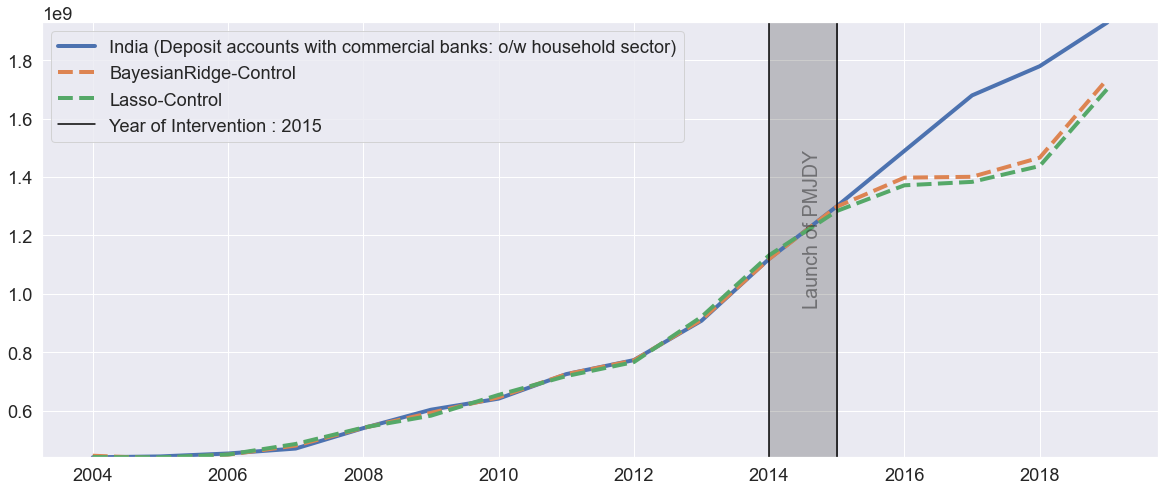

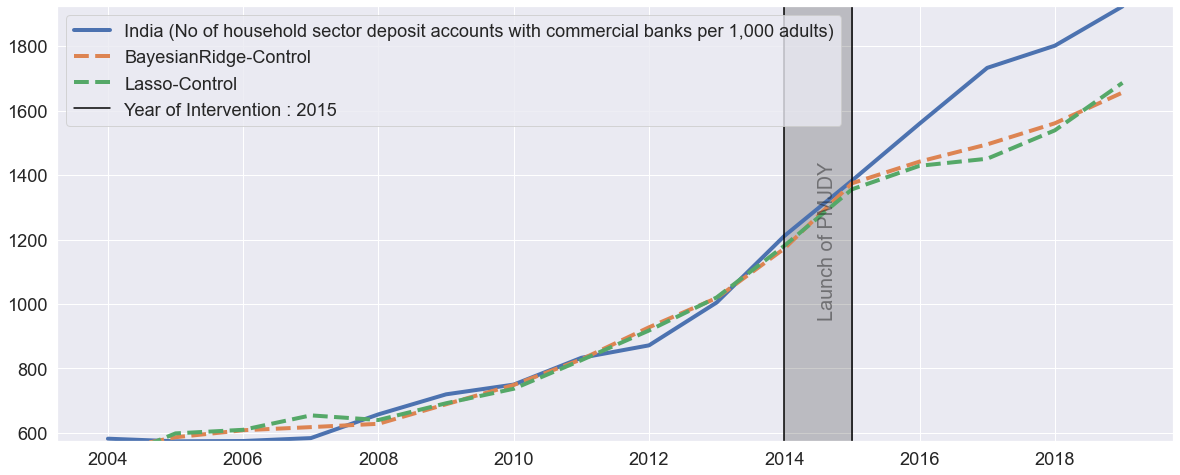

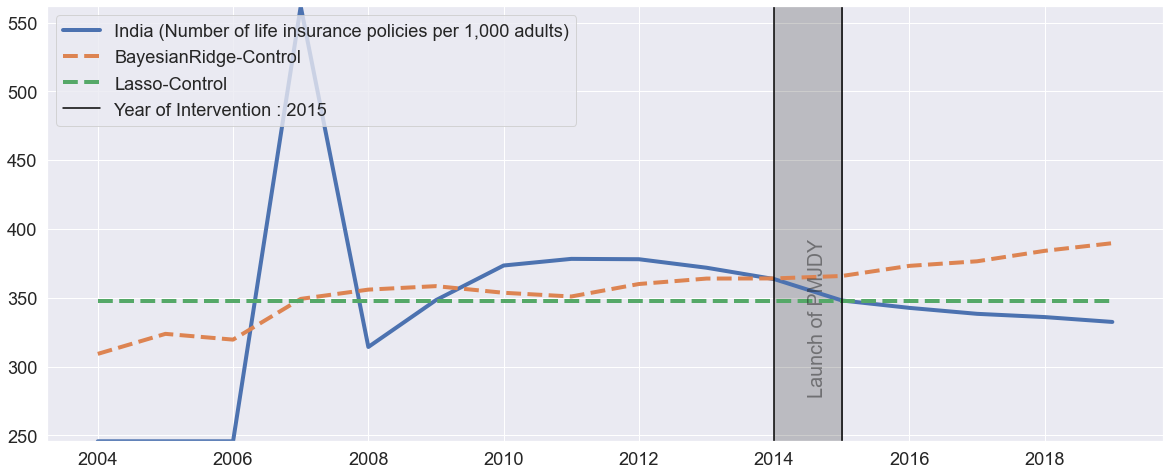

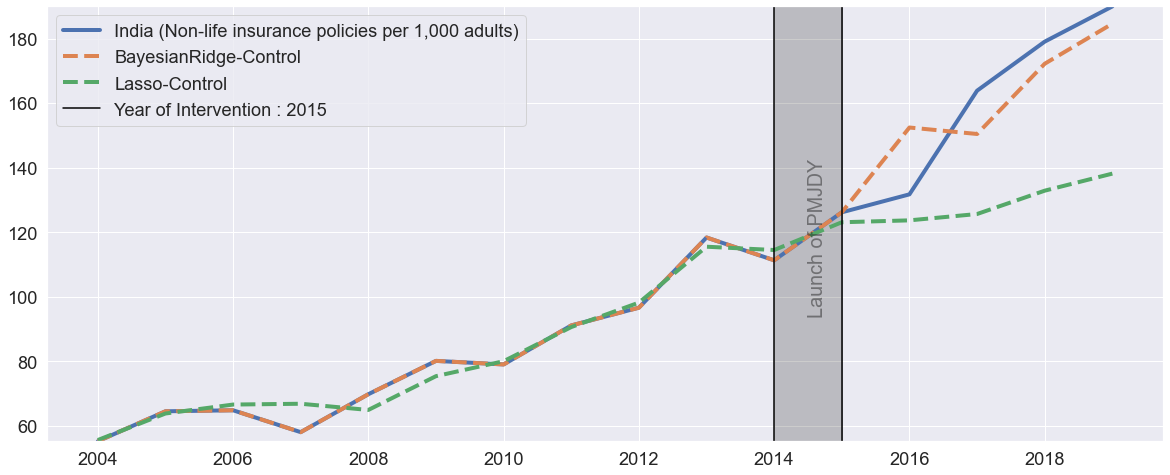

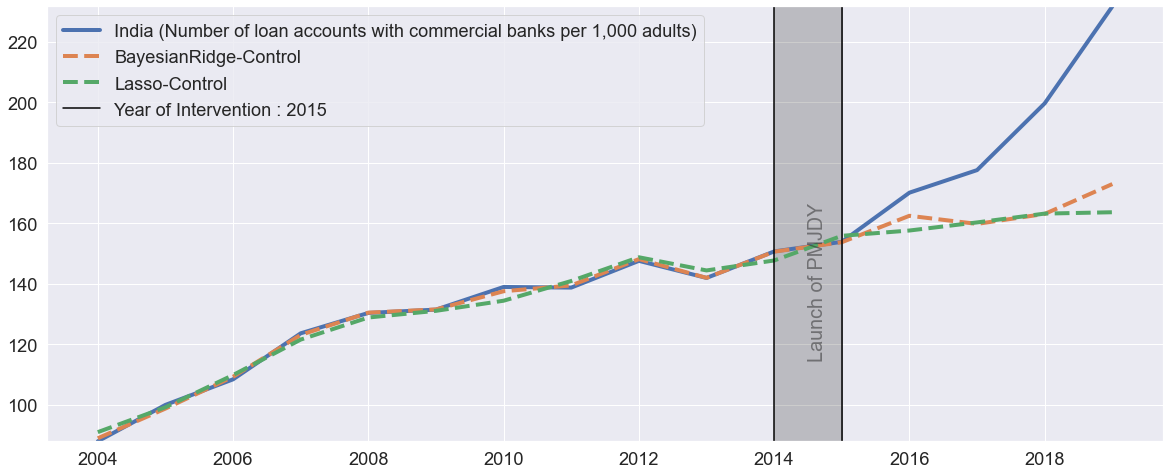

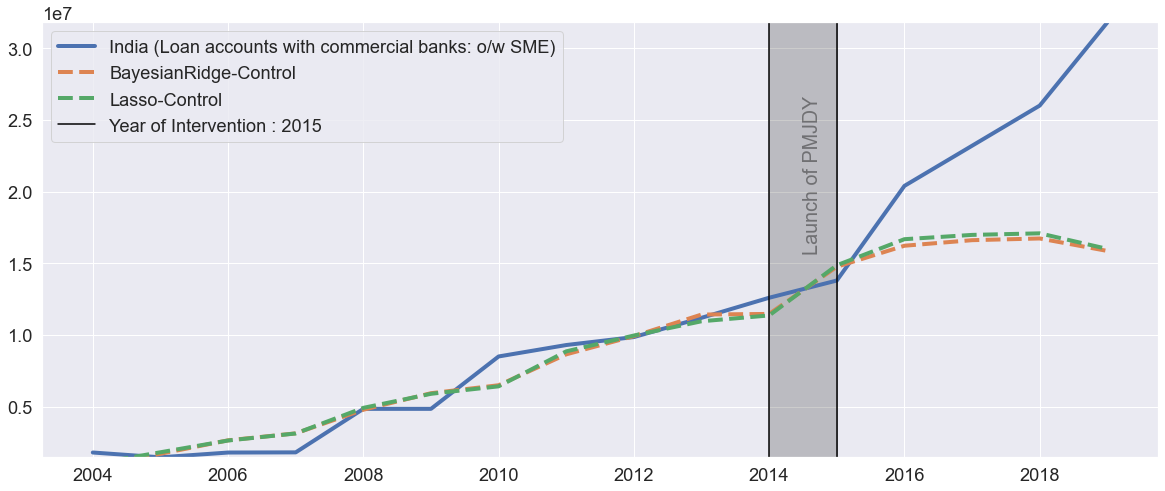

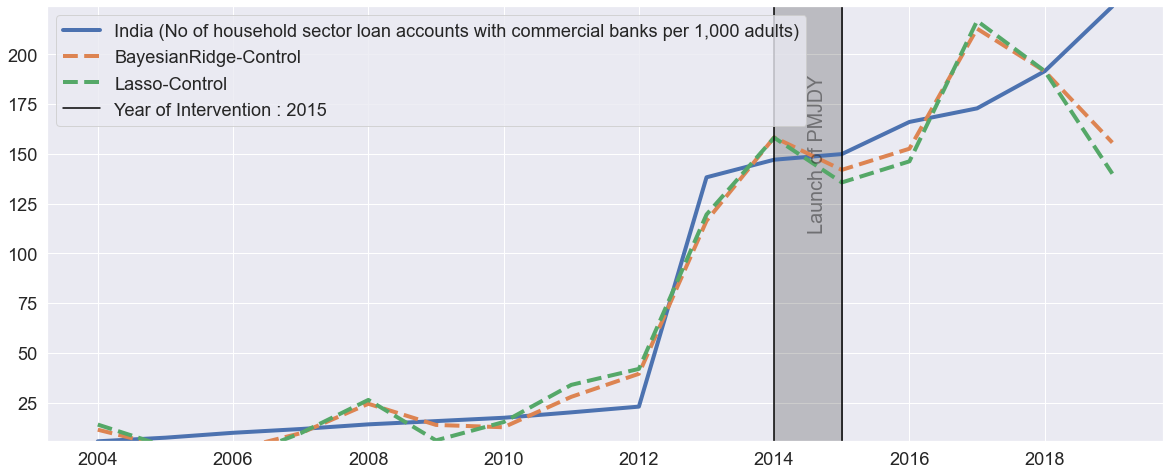

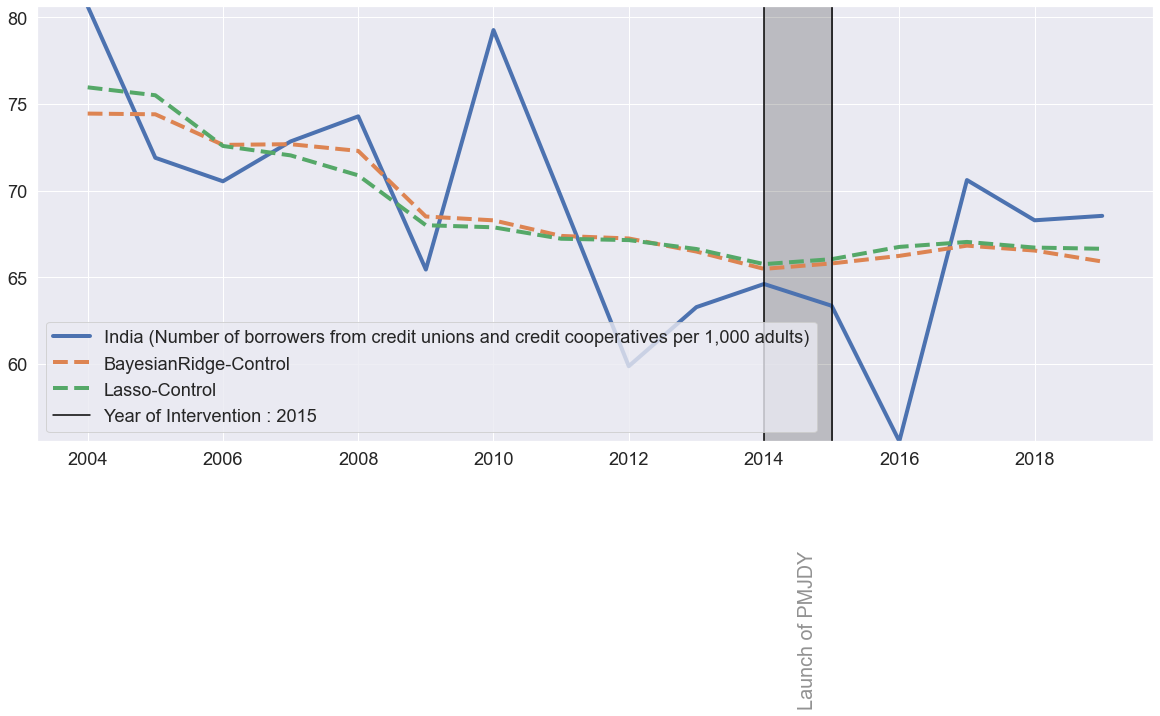

In [7]:
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)
#     m_rf = en.RandomForestRegressor().fit(Ypre_donor,Ypre_target)
    
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)
#     Y_target_rf = m_rf.predict(Y_donor.fillna(method='ffill'))
    
    fig = plt.figure(figsize=(20,8))
    sns.set(font_scale=1.65)
    plt.plot(np.arange(2004,2020),Y_target,lw='4')
    plt.plot(np.arange(2004,2020),Y_target_bayesian,ls='--',lw=4)
    plt.plot(np.arange(2004,2020),Y_target_lasso,ls='--',lw=4)
#     plt.plot(np.arange(2004,2020),Y_target_rf)
    plt.axvline(time_intervention-1,c='black')
    plt.axvline(time_intervention+0,c='black')
    plt.fill_betweenx(y=Y_target.sort_values(by='India').to_numpy()[:,0],
                      x1=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention-1),
                      x2=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention),alpha=0.2,color='black')
    plt.text(2014.5,np.max(Y_target.to_numpy())/2,'Launch of PMJDY',rotation=90,alpha=0.5)
    plt.ylim((np.min(Y_target.to_numpy()),np.max(Y_target.to_numpy())))
    plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Lasso-Control','Year of Intervention : 2015'])
    fig.savefig('%s_%s.png'%(target,series.replace('/','')))

# Placebo Test

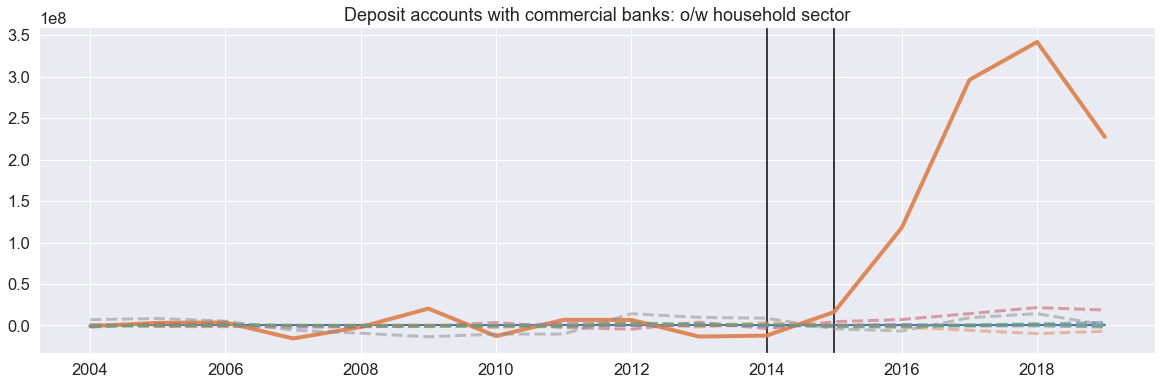

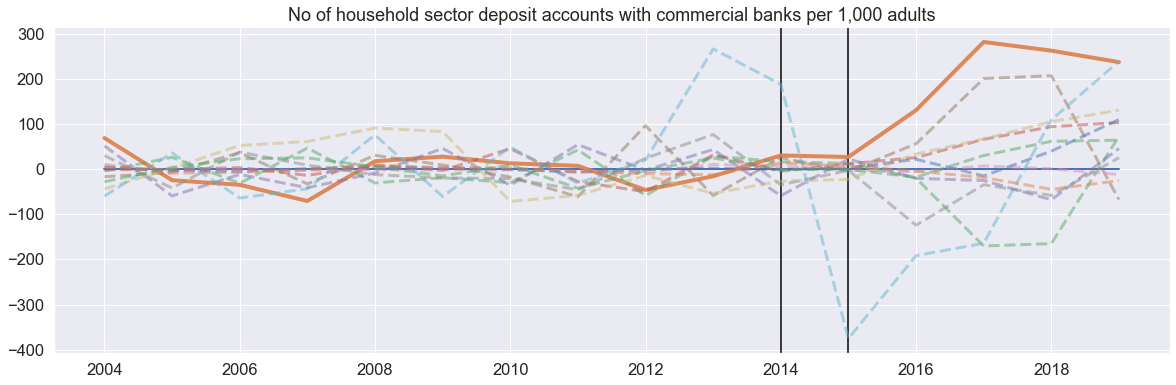

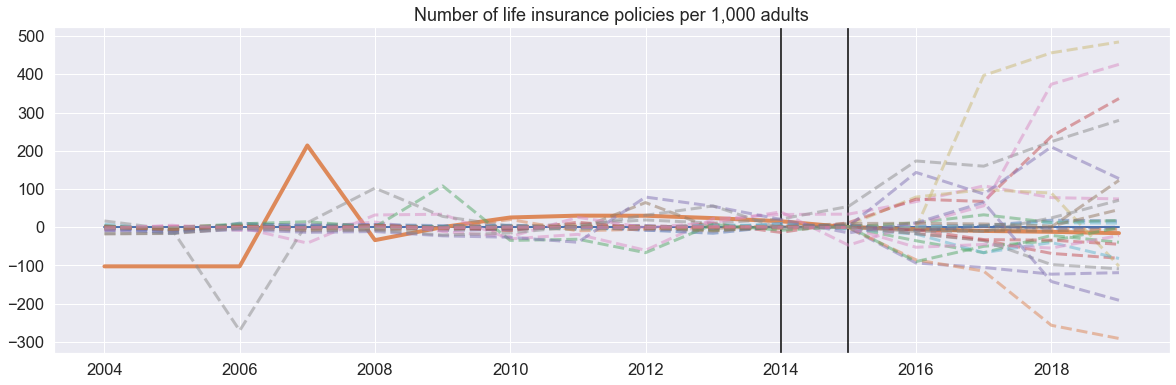

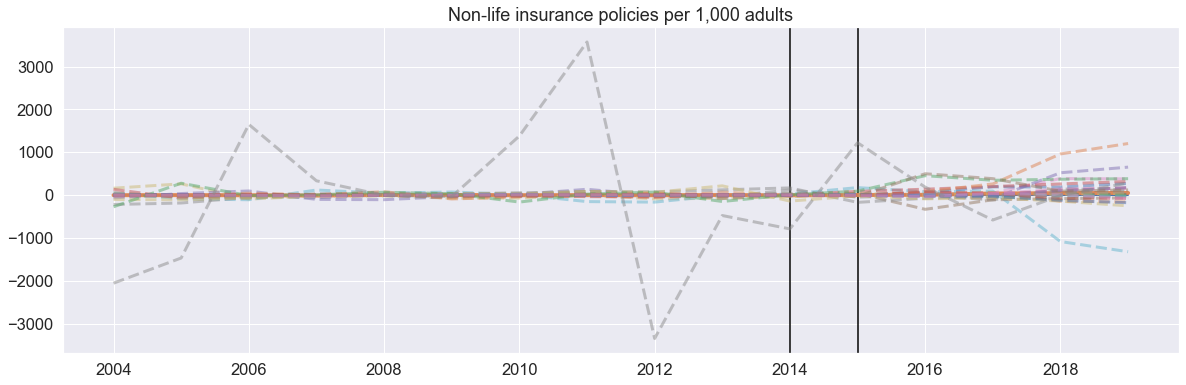

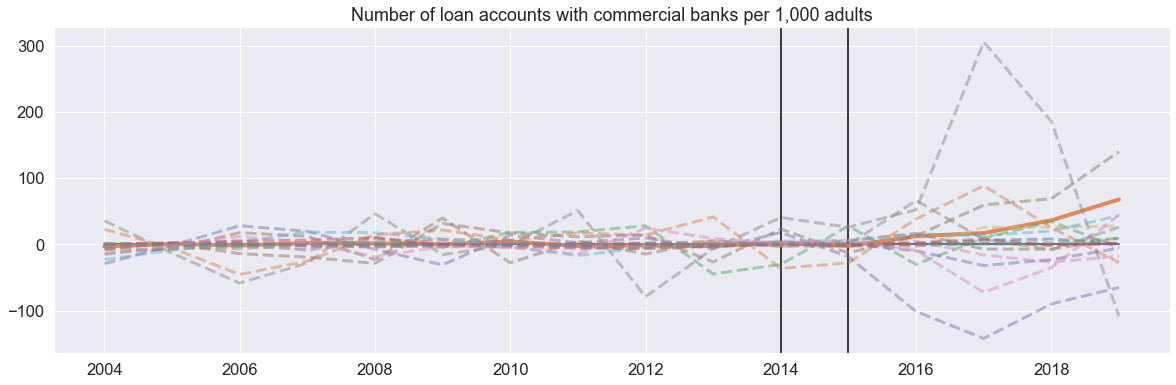

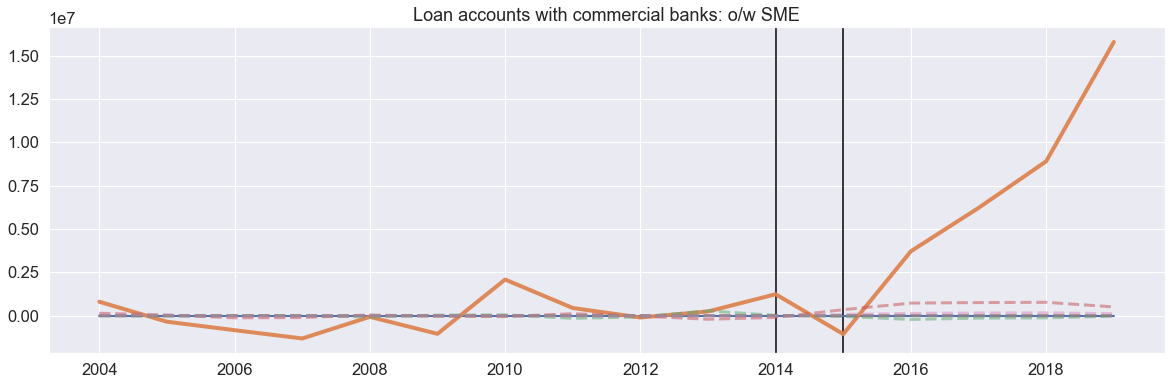

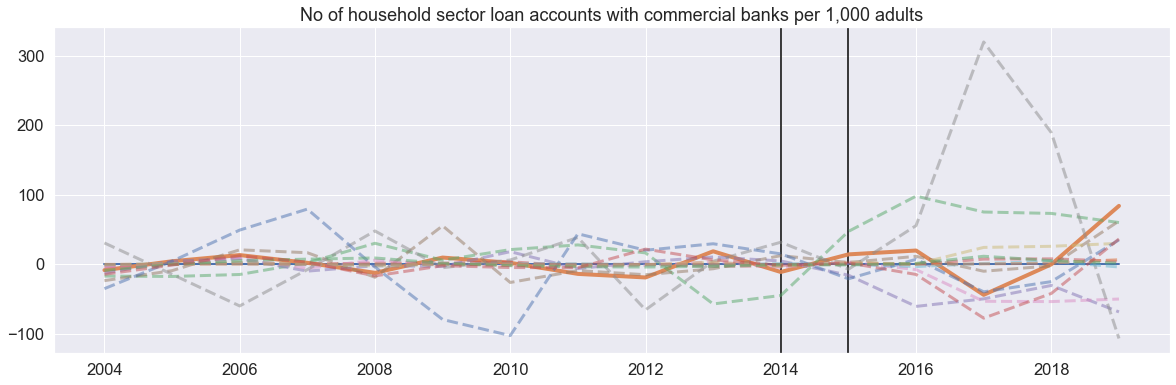

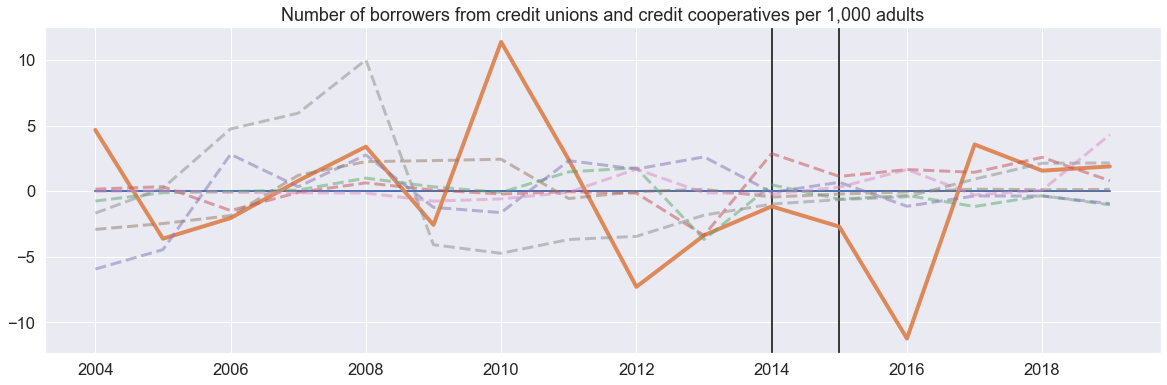

In [79]:
sns.set(font_scale=1.5)
pval = {}
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    Ypost_donor = Y_donor.loc[Y_donor.index>time_intervention]
    Ypost_target = Y_target.loc[Y_target.index>time_intervention]
    fig = plt.figure(figsize=(20,6))
    
    plt.axvline(time_intervention-1,c='black')
    plt.axvline(time_intervention+0,c='black')
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    
    rmse_pre_target = np.sqrt(np.mean(np.square(Ypre_target.values.reshape(-1,) - m_lasso.predict(Ypre_donor.fillna(method='ffill')).reshape(-1,))))
    rmse_post_target = np.sqrt(np.mean(np.square(Ypost_target.values.reshape(-1,) - m_lasso.predict(Ypost_donor.fillna(method='ffill')).reshape(-1,))))
    
    rmse_pre_placebo = []
    rmse_post_placebo = []
    
    plt.plot(np.arange(2004,2020),Y_target-Y_target,lw='2')
    plt.plot(np.arange(2004,2020),Y_target.to_numpy().reshape(-1,)-Y_target_lasso.reshape(-1,),lw='4',alpha=0.95)

    plt.title(series)
    for col in Y_donor.columns:
        Y_placebo = Y_donor[col]
        Ypre_placebo = Ypre_donor[col]
        Ypost_placebo = Ypost_donor[col]
        
        m_lasso = lm.LassoCV().fit(Ypre_donor.drop(columns=[col]),Ypre_placebo)
        Y_placebo_lasso = m_lasso.predict(Y_donor.drop(columns=[col]))
        
        rmse_pre_placebo += [np.sqrt(np.mean(np.square(Ypre_placebo.values.reshape(-1,) - m_lasso.predict(Ypre_donor.drop(columns=[col])).reshape(-1,))))]
        rmse_post_placebo += [np.sqrt(np.mean(np.square(Ypost_placebo.values.reshape(-1,) - m_lasso.predict(Ypost_donor.drop(columns=[col])).reshape(-1,))))] 
        
        plt.plot(np.arange(2004,2020),Y_placebo - Y_placebo_lasso,ls='--',lw=3,alpha=0.5)

#         plt.text(2014.5,np.max(Y_placebo.to_numpy())/2,'Launch of PMJDY',rotation=90,alpha=0.5)
#         plt.ylim((np.min(Y_placebo.to_numpy()),np.max(Y_placebo.to_numpy())))
#         plt.legend(['%s (%s)'%(col,series)])

    r_target = rmse_post_target/rmse_pre_target
    r_placebo = np.array(rmse_post_placebo)/np.array(rmse_pre_placebo)
    p = np.sum(r_placebo>r_target)/len(r_placebo)
    pval[series] = p
    fig.savefig('placebo_study_%s_%s.png'%(target,series.replace('/','')))

In [81]:
pval

{'Deposit accounts with commercial banks: o/w household sector': 0.0,
 'No of household sector deposit accounts with commercial banks per 1,000 adults': 0.09090909090909091,
 'Number of life insurance policies per 1,000 adults': 1.0,
 'Non-life insurance policies per 1,000 adults': 0.2692307692307692,
 'Number of loan accounts with commercial banks per 1,000 adults': 0.0625,
 'Loan accounts with commercial banks: o/w SME': 0.0,
 'No of household sector loan accounts with commercial banks per 1,000 adults': 0.5833333333333334,
 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults': 0.16666666666666666}

# Credence

In [9]:
import torch

In [10]:
import os
import sys
sys.path.append(os.path.abspath('../python'))

In [11]:
import train_arvae
import verify_causal_model

## Setting up the training data

In [63]:
B = 5000 #number of units to train the neural net
N = 10 #number of timeseries in a unit
T = 16 #length of each timeseries

series_names = np.random.choice(bundles_names,size = B,replace = True)
for i in range(0,B):
    series = series_names[i]
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    Nmax = Y_donor.shape[1]
    idxs = np.random.choice(a = Nmax,size = N,replace = True)
    data_i = Y_donor.iloc[:,list(idxs)].values.reshape((T,1,N))
    data_i = (data_i - np.mean(data_i))/np.std(data_i)
#     print('%.2f,%.2f'%(np.mean(data_i),np.std(data_i)))
    if i == 0:
        data = data_i
    else:
        data = np.concatenate((data,data_i),axis=1)

data_2d = train_arvae.convert_to_2d(data)

In [64]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (5000, 160)

Mean of raw data: 0.000
Std. dev of raw data: 1.000


In [65]:
hyper_params = {}
hyper_params['epochs'] = 1000
hyper_params['latent_dim'] = 8 #Z
hyper_params['hidden_dims'] = [32,16]
hyper_params['kld_weight'] = 5e-03

In [66]:
vae_model, runner = train_arvae.train(data_2d, hyper_params, 
                          output_checkpoint_path='ar_vae_jandhan_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 5.7 K 
1 | fc_mu         | Linear     | 136   
2 | fc_var        | Linear     | 136   
3 | decoder_input | Linear     | 144   
4 | decoder       | Sequential | 544   
5 | final_layer   | Sequential | 5.3 K 
---------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.0475, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0469, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.1272, grad_fn=<MeanBackward0>), 'KLD_weight': 0.005}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0468), 'kld_loss': tensor(0.1272), 'reconstruction_loss': tensor(1.0462)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0305), 'kld_loss': tensor(0.1248), 'reconstruction_loss': tensor(1.0299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0179), 'kld_loss': tensor(0.1218), 'reconstruction_loss': tensor(1.0173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0086), 'kld_loss': tensor(0.1184), 'reconstruction_loss': tensor(1.0080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0013), 'kld_loss': tensor(0.1166), 'reconstruction_loss': tensor(1.0007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9959), 'kld_loss': tensor(0.1228), 'reconstruction_loss': tensor(0.9952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9918), 'kld_loss': tensor(0.1426), 'reconstruction_loss': tensor(0.9911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9882), 'kld_loss': tensor(0.1725), 'reconstruction_loss': tensor(0.9873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.2002), 'reconstruction_loss': tensor(0.9843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.2232), 'reconstruction_loss': tensor(0.9816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.2377), 'reconstruction_loss': tensor(0.9791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.2529), 'reconstruction_loss': tensor(0.9771)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9765), 'kld_loss': tensor(0.2836), 'reconstruction_loss': tensor(0.9751)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.3399), 'reconstruction_loss': tensor(0.9733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.4356), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9714), 'kld_loss': tensor(0.5864), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.8058), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(1.1053), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(1.4588), 'reconstruction_loss': tensor(0.9548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(1.7616), 'reconstruction_loss': tensor(0.9489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(2.0244), 'reconstruction_loss': tensor(0.9427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9476), 'kld_loss': tensor(2.3511), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9417), 'kld_loss': tensor(2.6689), 'reconstruction_loss': tensor(0.9284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9351), 'kld_loss': tensor(2.9587), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9283), 'kld_loss': tensor(3.1123), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9216), 'kld_loss': tensor(3.3186), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9114), 'kld_loss': tensor(3.4197), 'reconstruction_loss': tensor(0.8943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9040), 'kld_loss': tensor(3.5965), 'reconstruction_loss': tensor(0.8860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8960), 'kld_loss': tensor(3.9015), 'reconstruction_loss': tensor(0.8765)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8869), 'kld_loss': tensor(4.0892), 'reconstruction_loss': tensor(0.8664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8785), 'kld_loss': tensor(4.2625), 'reconstruction_loss': tensor(0.8571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8689), 'kld_loss': tensor(4.5647), 'reconstruction_loss': tensor(0.8461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8584), 'kld_loss': tensor(4.8375), 'reconstruction_loss': tensor(0.8342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8484), 'kld_loss': tensor(5.2407), 'reconstruction_loss': tensor(0.8222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8376), 'kld_loss': tensor(5.6852), 'reconstruction_loss': tensor(0.8092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8274), 'kld_loss': tensor(6.0017), 'reconstruction_loss': tensor(0.7974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8172), 'kld_loss': tensor(6.4885), 'reconstruction_loss': tensor(0.7848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8062), 'kld_loss': tensor(6.8821), 'reconstruction_loss': tensor(0.7718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7962), 'kld_loss': tensor(7.1888), 'reconstruction_loss': tensor(0.7603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7859), 'kld_loss': tensor(7.3272), 'reconstruction_loss': tensor(0.7492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7768), 'kld_loss': tensor(7.2403), 'reconstruction_loss': tensor(0.7406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7681), 'kld_loss': tensor(7.0724), 'reconstruction_loss': tensor(0.7327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7607), 'kld_loss': tensor(6.9995), 'reconstruction_loss': tensor(0.7257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7549), 'kld_loss': tensor(6.9978), 'reconstruction_loss': tensor(0.7199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7499), 'kld_loss': tensor(6.9345), 'reconstruction_loss': tensor(0.7152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7446), 'kld_loss': tensor(6.9815), 'reconstruction_loss': tensor(0.7097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7402), 'kld_loss': tensor(7.1393), 'reconstruction_loss': tensor(0.7045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7352), 'kld_loss': tensor(7.1380), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7315), 'kld_loss': tensor(7.2161), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7282), 'kld_loss': tensor(7.3224), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7242), 'kld_loss': tensor(7.3045), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7208), 'kld_loss': tensor(7.2779), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7172), 'kld_loss': tensor(7.3185), 'reconstruction_loss': tensor(0.6806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7139), 'kld_loss': tensor(7.3155), 'reconstruction_loss': tensor(0.6773)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7099), 'kld_loss': tensor(7.3062), 'reconstruction_loss': tensor(0.6734)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7059), 'kld_loss': tensor(7.2274), 'reconstruction_loss': tensor(0.6698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(7.1078), 'reconstruction_loss': tensor(0.6665)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(6.9882), 'reconstruction_loss': tensor(0.6631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(6.9573), 'reconstruction_loss': tensor(0.6595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(6.9855), 'reconstruction_loss': tensor(0.6541)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(7.0379), 'reconstruction_loss': tensor(0.6497)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6804), 'kld_loss': tensor(7.1058), 'reconstruction_loss': tensor(0.6449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(7.1274), 'reconstruction_loss': tensor(0.6397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(7.1346), 'reconstruction_loss': tensor(0.6351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(7.1059), 'reconstruction_loss': tensor(0.6305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(7.1423), 'reconstruction_loss': tensor(0.6264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6565), 'kld_loss': tensor(7.1914), 'reconstruction_loss': tensor(0.6205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6524), 'kld_loss': tensor(7.2159), 'reconstruction_loss': tensor(0.6163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6488), 'kld_loss': tensor(7.2495), 'reconstruction_loss': tensor(0.6125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6454), 'kld_loss': tensor(7.2716), 'reconstruction_loss': tensor(0.6090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6414), 'kld_loss': tensor(7.2221), 'reconstruction_loss': tensor(0.6053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6376), 'kld_loss': tensor(7.2132), 'reconstruction_loss': tensor(0.6015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6343), 'kld_loss': tensor(7.2080), 'reconstruction_loss': tensor(0.5982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6312), 'kld_loss': tensor(7.1760), 'reconstruction_loss': tensor(0.5953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6278), 'kld_loss': tensor(7.1898), 'reconstruction_loss': tensor(0.5919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6251), 'kld_loss': tensor(7.2121), 'reconstruction_loss': tensor(0.5890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6223), 'kld_loss': tensor(7.1918), 'reconstruction_loss': tensor(0.5864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6198), 'kld_loss': tensor(7.1794), 'reconstruction_loss': tensor(0.5839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6174), 'kld_loss': tensor(7.1859), 'reconstruction_loss': tensor(0.5814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6150), 'kld_loss': tensor(7.2061), 'reconstruction_loss': tensor(0.5790)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6125), 'kld_loss': tensor(7.2390), 'reconstruction_loss': tensor(0.5763)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6101), 'kld_loss': tensor(7.2755), 'reconstruction_loss': tensor(0.5737)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6073), 'kld_loss': tensor(7.3107), 'reconstruction_loss': tensor(0.5708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6055), 'kld_loss': tensor(7.3011), 'reconstruction_loss': tensor(0.5690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6029), 'kld_loss': tensor(7.2554), 'reconstruction_loss': tensor(0.5666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6006), 'kld_loss': tensor(7.2553), 'reconstruction_loss': tensor(0.5644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5971), 'kld_loss': tensor(7.3021), 'reconstruction_loss': tensor(0.5606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5953), 'kld_loss': tensor(7.3184), 'reconstruction_loss': tensor(0.5587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5927), 'kld_loss': tensor(7.3544), 'reconstruction_loss': tensor(0.5559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5903), 'kld_loss': tensor(7.4253), 'reconstruction_loss': tensor(0.5532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5861), 'kld_loss': tensor(7.4553), 'reconstruction_loss': tensor(0.5489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5835), 'kld_loss': tensor(7.4963), 'reconstruction_loss': tensor(0.5460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5785), 'kld_loss': tensor(7.5697), 'reconstruction_loss': tensor(0.5407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5749), 'kld_loss': tensor(7.6439), 'reconstruction_loss': tensor(0.5367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5710), 'kld_loss': tensor(7.7315), 'reconstruction_loss': tensor(0.5323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5657), 'kld_loss': tensor(7.8731), 'reconstruction_loss': tensor(0.5264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5618), 'kld_loss': tensor(8.0588), 'reconstruction_loss': tensor(0.5215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5566), 'kld_loss': tensor(8.2569), 'reconstruction_loss': tensor(0.5154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5538), 'kld_loss': tensor(8.4797), 'reconstruction_loss': tensor(0.5114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5483), 'kld_loss': tensor(8.7218), 'reconstruction_loss': tensor(0.5047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5443), 'kld_loss': tensor(8.9278), 'reconstruction_loss': tensor(0.4996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5389), 'kld_loss': tensor(9.0698), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5348), 'kld_loss': tensor(9.1636), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5303), 'kld_loss': tensor(9.1980), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5255), 'kld_loss': tensor(9.1545), 'reconstruction_loss': tensor(0.4798)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5223), 'kld_loss': tensor(9.1362), 'reconstruction_loss': tensor(0.4767)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5188), 'kld_loss': tensor(9.1910), 'reconstruction_loss': tensor(0.4729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5158), 'kld_loss': tensor(9.2724), 'reconstruction_loss': tensor(0.4694)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5136), 'kld_loss': tensor(9.3672), 'reconstruction_loss': tensor(0.4668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5094), 'kld_loss': tensor(9.4671), 'reconstruction_loss': tensor(0.4620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5069), 'kld_loss': tensor(9.5877), 'reconstruction_loss': tensor(0.4590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5049), 'kld_loss': tensor(9.6405), 'reconstruction_loss': tensor(0.4567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.5011), 'kld_loss': tensor(9.6710), 'reconstruction_loss': tensor(0.4528)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4975), 'kld_loss': tensor(9.6968), 'reconstruction_loss': tensor(0.4490)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4956), 'kld_loss': tensor(9.6887), 'reconstruction_loss': tensor(0.4472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4942), 'kld_loss': tensor(9.6354), 'reconstruction_loss': tensor(0.4460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4930), 'kld_loss': tensor(9.5481), 'reconstruction_loss': tensor(0.4452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4903), 'kld_loss': tensor(9.4885), 'reconstruction_loss': tensor(0.4428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4875), 'kld_loss': tensor(9.4137), 'reconstruction_loss': tensor(0.4405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4828), 'kld_loss': tensor(9.4316), 'reconstruction_loss': tensor(0.4357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4813), 'kld_loss': tensor(9.4789), 'reconstruction_loss': tensor(0.4339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4814), 'kld_loss': tensor(9.5256), 'reconstruction_loss': tensor(0.4338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4773), 'kld_loss': tensor(9.5690), 'reconstruction_loss': tensor(0.4294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4737), 'kld_loss': tensor(9.5905), 'reconstruction_loss': tensor(0.4257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4721), 'kld_loss': tensor(9.6251), 'reconstruction_loss': tensor(0.4240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4704), 'kld_loss': tensor(9.6560), 'reconstruction_loss': tensor(0.4221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4673), 'kld_loss': tensor(9.6768), 'reconstruction_loss': tensor(0.4189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4650), 'kld_loss': tensor(9.7320), 'reconstruction_loss': tensor(0.4163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4640), 'kld_loss': tensor(9.7783), 'reconstruction_loss': tensor(0.4151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4620), 'kld_loss': tensor(9.7828), 'reconstruction_loss': tensor(0.4131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4590), 'kld_loss': tensor(9.7919), 'reconstruction_loss': tensor(0.4100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4564), 'kld_loss': tensor(9.7952), 'reconstruction_loss': tensor(0.4074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4556), 'kld_loss': tensor(9.8001), 'reconstruction_loss': tensor(0.4066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4539), 'kld_loss': tensor(9.8055), 'reconstruction_loss': tensor(0.4049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4520), 'kld_loss': tensor(9.8001), 'reconstruction_loss': tensor(0.4030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4514), 'kld_loss': tensor(9.8261), 'reconstruction_loss': tensor(0.4023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4496), 'kld_loss': tensor(9.8629), 'reconstruction_loss': tensor(0.4003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4470), 'kld_loss': tensor(9.9438), 'reconstruction_loss': tensor(0.3973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4445), 'kld_loss': tensor(10.0015), 'reconstruction_loss': tensor(0.3945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4425), 'kld_loss': tensor(10.0676), 'reconstruction_loss': tensor(0.3921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4397), 'kld_loss': tensor(10.1241), 'reconstruction_loss': tensor(0.3891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4384), 'kld_loss': tensor(10.1352), 'reconstruction_loss': tensor(0.3877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4362), 'kld_loss': tensor(10.1867), 'reconstruction_loss': tensor(0.3853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4356), 'kld_loss': tensor(10.2020), 'reconstruction_loss': tensor(0.3845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4349), 'kld_loss': tensor(10.2872), 'reconstruction_loss': tensor(0.3835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4325), 'kld_loss': tensor(10.3590), 'reconstruction_loss': tensor(0.3808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4315), 'kld_loss': tensor(10.4818), 'reconstruction_loss': tensor(0.3791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4281), 'kld_loss': tensor(10.5222), 'reconstruction_loss': tensor(0.3755)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4246), 'kld_loss': tensor(10.5810), 'reconstruction_loss': tensor(0.3717)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4230), 'kld_loss': tensor(10.6045), 'reconstruction_loss': tensor(0.3700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4229), 'kld_loss': tensor(10.6007), 'reconstruction_loss': tensor(0.3699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4205), 'kld_loss': tensor(10.6187), 'reconstruction_loss': tensor(0.3674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4180), 'kld_loss': tensor(10.6241), 'reconstruction_loss': tensor(0.3649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4160), 'kld_loss': tensor(10.6294), 'reconstruction_loss': tensor(0.3628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4146), 'kld_loss': tensor(10.6495), 'reconstruction_loss': tensor(0.3614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4141), 'kld_loss': tensor(10.6593), 'reconstruction_loss': tensor(0.3608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4135), 'kld_loss': tensor(10.6690), 'reconstruction_loss': tensor(0.3602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4099), 'kld_loss': tensor(10.7133), 'reconstruction_loss': tensor(0.3563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4076), 'kld_loss': tensor(10.8010), 'reconstruction_loss': tensor(0.3536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4071), 'kld_loss': tensor(10.8510), 'reconstruction_loss': tensor(0.3529)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4061), 'kld_loss': tensor(10.8588), 'reconstruction_loss': tensor(0.3518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4031), 'kld_loss': tensor(10.8733), 'reconstruction_loss': tensor(0.3487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4020), 'kld_loss': tensor(10.8992), 'reconstruction_loss': tensor(0.3475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4012), 'kld_loss': tensor(10.9174), 'reconstruction_loss': tensor(0.3466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.4003), 'kld_loss': tensor(10.9323), 'reconstruction_loss': tensor(0.3456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3977), 'kld_loss': tensor(10.9242), 'reconstruction_loss': tensor(0.3431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3964), 'kld_loss': tensor(10.9098), 'reconstruction_loss': tensor(0.3419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3942), 'kld_loss': tensor(10.8905), 'reconstruction_loss': tensor(0.3398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3935), 'kld_loss': tensor(10.8621), 'reconstruction_loss': tensor(0.3392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3926), 'kld_loss': tensor(10.8529), 'reconstruction_loss': tensor(0.3384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3913), 'kld_loss': tensor(10.8384), 'reconstruction_loss': tensor(0.3371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3896), 'kld_loss': tensor(10.8455), 'reconstruction_loss': tensor(0.3353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3881), 'kld_loss': tensor(10.8463), 'reconstruction_loss': tensor(0.3338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3874), 'kld_loss': tensor(10.8360), 'reconstruction_loss': tensor(0.3332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3859), 'kld_loss': tensor(10.8517), 'reconstruction_loss': tensor(0.3317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3853), 'kld_loss': tensor(10.8886), 'reconstruction_loss': tensor(0.3309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3836), 'kld_loss': tensor(10.8820), 'reconstruction_loss': tensor(0.3292)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3829), 'kld_loss': tensor(10.8518), 'reconstruction_loss': tensor(0.3286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3827), 'kld_loss': tensor(10.8217), 'reconstruction_loss': tensor(0.3286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3813), 'kld_loss': tensor(10.7859), 'reconstruction_loss': tensor(0.3274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3801), 'kld_loss': tensor(10.7759), 'reconstruction_loss': tensor(0.3263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3791), 'kld_loss': tensor(10.7810), 'reconstruction_loss': tensor(0.3252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3789), 'kld_loss': tensor(10.7655), 'reconstruction_loss': tensor(0.3251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3783), 'kld_loss': tensor(10.7786), 'reconstruction_loss': tensor(0.3244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3770), 'kld_loss': tensor(10.8067), 'reconstruction_loss': tensor(0.3230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3759), 'kld_loss': tensor(10.8109), 'reconstruction_loss': tensor(0.3218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3758), 'kld_loss': tensor(10.7971), 'reconstruction_loss': tensor(0.3218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3748), 'kld_loss': tensor(10.8069), 'reconstruction_loss': tensor(0.3207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3733), 'kld_loss': tensor(10.7929), 'reconstruction_loss': tensor(0.3193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3730), 'kld_loss': tensor(10.7614), 'reconstruction_loss': tensor(0.3192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3733), 'kld_loss': tensor(10.7537), 'reconstruction_loss': tensor(0.3196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3719), 'kld_loss': tensor(10.7519), 'reconstruction_loss': tensor(0.3182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3713), 'kld_loss': tensor(10.7565), 'reconstruction_loss': tensor(0.3175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3704), 'kld_loss': tensor(10.7480), 'reconstruction_loss': tensor(0.3167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3694), 'kld_loss': tensor(10.7412), 'reconstruction_loss': tensor(0.3157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3680), 'kld_loss': tensor(10.7311), 'reconstruction_loss': tensor(0.3143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3675), 'kld_loss': tensor(10.7426), 'reconstruction_loss': tensor(0.3138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3675), 'kld_loss': tensor(10.7834), 'reconstruction_loss': tensor(0.3136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3673), 'kld_loss': tensor(10.8130), 'reconstruction_loss': tensor(0.3132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3666), 'kld_loss': tensor(10.7905), 'reconstruction_loss': tensor(0.3126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3663), 'kld_loss': tensor(10.7635), 'reconstruction_loss': tensor(0.3125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3649), 'kld_loss': tensor(10.7722), 'reconstruction_loss': tensor(0.3111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3643), 'kld_loss': tensor(10.7755), 'reconstruction_loss': tensor(0.3105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3637), 'kld_loss': tensor(10.7360), 'reconstruction_loss': tensor(0.3100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3632), 'kld_loss': tensor(10.7169), 'reconstruction_loss': tensor(0.3096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3617), 'kld_loss': tensor(10.7269), 'reconstruction_loss': tensor(0.3080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3621), 'kld_loss': tensor(10.7446), 'reconstruction_loss': tensor(0.3084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3617), 'kld_loss': tensor(10.7573), 'reconstruction_loss': tensor(0.3079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3608), 'kld_loss': tensor(10.7748), 'reconstruction_loss': tensor(0.3069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3608), 'kld_loss': tensor(10.7861), 'reconstruction_loss': tensor(0.3069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3602), 'kld_loss': tensor(10.7914), 'reconstruction_loss': tensor(0.3062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3588), 'kld_loss': tensor(10.8090), 'reconstruction_loss': tensor(0.3048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3593), 'kld_loss': tensor(10.8090), 'reconstruction_loss': tensor(0.3052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3577), 'kld_loss': tensor(10.8084), 'reconstruction_loss': tensor(0.3037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3579), 'kld_loss': tensor(10.8204), 'reconstruction_loss': tensor(0.3038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3564), 'kld_loss': tensor(10.8290), 'reconstruction_loss': tensor(0.3023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3572), 'kld_loss': tensor(10.8445), 'reconstruction_loss': tensor(0.3029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3567), 'kld_loss': tensor(10.8262), 'reconstruction_loss': tensor(0.3025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3566), 'kld_loss': tensor(10.8096), 'reconstruction_loss': tensor(0.3026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3562), 'kld_loss': tensor(10.8022), 'reconstruction_loss': tensor(0.3022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3565), 'kld_loss': tensor(10.8356), 'reconstruction_loss': tensor(0.3024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3564), 'kld_loss': tensor(10.8260), 'reconstruction_loss': tensor(0.3023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3563), 'kld_loss': tensor(10.8313), 'reconstruction_loss': tensor(0.3022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3558), 'kld_loss': tensor(10.8479), 'reconstruction_loss': tensor(0.3016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3548), 'kld_loss': tensor(10.8487), 'reconstruction_loss': tensor(0.3005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3542), 'kld_loss': tensor(10.8168), 'reconstruction_loss': tensor(0.3001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3516), 'kld_loss': tensor(10.8063), 'reconstruction_loss': tensor(0.2976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3520), 'kld_loss': tensor(10.8105), 'reconstruction_loss': tensor(0.2980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3526), 'kld_loss': tensor(10.8157), 'reconstruction_loss': tensor(0.2986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3519), 'kld_loss': tensor(10.8017), 'reconstruction_loss': tensor(0.2979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3516), 'kld_loss': tensor(10.7880), 'reconstruction_loss': tensor(0.2976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3512), 'kld_loss': tensor(10.8216), 'reconstruction_loss': tensor(0.2971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3499), 'kld_loss': tensor(10.8739), 'reconstruction_loss': tensor(0.2956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3506), 'kld_loss': tensor(10.8892), 'reconstruction_loss': tensor(0.2962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3504), 'kld_loss': tensor(10.8844), 'reconstruction_loss': tensor(0.2960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3493), 'kld_loss': tensor(10.8785), 'reconstruction_loss': tensor(0.2949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3487), 'kld_loss': tensor(10.8827), 'reconstruction_loss': tensor(0.2943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3485), 'kld_loss': tensor(10.8647), 'reconstruction_loss': tensor(0.2942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3480), 'kld_loss': tensor(10.8476), 'reconstruction_loss': tensor(0.2938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3480), 'kld_loss': tensor(10.8442), 'reconstruction_loss': tensor(0.2938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3475), 'kld_loss': tensor(10.8411), 'reconstruction_loss': tensor(0.2932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3476), 'kld_loss': tensor(10.8814), 'reconstruction_loss': tensor(0.2932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3478), 'kld_loss': tensor(10.8942), 'reconstruction_loss': tensor(0.2933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3469), 'kld_loss': tensor(10.9323), 'reconstruction_loss': tensor(0.2922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3458), 'kld_loss': tensor(10.9477), 'reconstruction_loss': tensor(0.2910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3463), 'kld_loss': tensor(10.9593), 'reconstruction_loss': tensor(0.2915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3464), 'kld_loss': tensor(10.9700), 'reconstruction_loss': tensor(0.2915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3456), 'kld_loss': tensor(10.9605), 'reconstruction_loss': tensor(0.2908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3446), 'kld_loss': tensor(10.9523), 'reconstruction_loss': tensor(0.2898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3446), 'kld_loss': tensor(10.9446), 'reconstruction_loss': tensor(0.2898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3452), 'kld_loss': tensor(10.9258), 'reconstruction_loss': tensor(0.2906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3440), 'kld_loss': tensor(10.9134), 'reconstruction_loss': tensor(0.2894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3440), 'kld_loss': tensor(10.9155), 'reconstruction_loss': tensor(0.2894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3431), 'kld_loss': tensor(10.9087), 'reconstruction_loss': tensor(0.2885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3436), 'kld_loss': tensor(10.9224), 'reconstruction_loss': tensor(0.2890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3428), 'kld_loss': tensor(10.9395), 'reconstruction_loss': tensor(0.2881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3423), 'kld_loss': tensor(10.9539), 'reconstruction_loss': tensor(0.2876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3412), 'kld_loss': tensor(10.9717), 'reconstruction_loss': tensor(0.2863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3419), 'kld_loss': tensor(10.9651), 'reconstruction_loss': tensor(0.2871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3410), 'kld_loss': tensor(10.9539), 'reconstruction_loss': tensor(0.2862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3416), 'kld_loss': tensor(10.9750), 'reconstruction_loss': tensor(0.2867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3415), 'kld_loss': tensor(10.9948), 'reconstruction_loss': tensor(0.2865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3417), 'kld_loss': tensor(11.0027), 'reconstruction_loss': tensor(0.2867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3420), 'kld_loss': tensor(10.9664), 'reconstruction_loss': tensor(0.2872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3408), 'kld_loss': tensor(10.9981), 'reconstruction_loss': tensor(0.2858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3415), 'kld_loss': tensor(10.9946), 'reconstruction_loss': tensor(0.2865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3416), 'kld_loss': tensor(11.0068), 'reconstruction_loss': tensor(0.2866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3408), 'kld_loss': tensor(11.0088), 'reconstruction_loss': tensor(0.2857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3402), 'kld_loss': tensor(11.0296), 'reconstruction_loss': tensor(0.2851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3393), 'kld_loss': tensor(11.0433), 'reconstruction_loss': tensor(0.2841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3390), 'kld_loss': tensor(11.0687), 'reconstruction_loss': tensor(0.2837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3396), 'kld_loss': tensor(11.0345), 'reconstruction_loss': tensor(0.2844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3394), 'kld_loss': tensor(11.0230), 'reconstruction_loss': tensor(0.2843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3377), 'kld_loss': tensor(11.0193), 'reconstruction_loss': tensor(0.2826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3383), 'kld_loss': tensor(11.0258), 'reconstruction_loss': tensor(0.2832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3385), 'kld_loss': tensor(11.0387), 'reconstruction_loss': tensor(0.2833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3371), 'kld_loss': tensor(11.0455), 'reconstruction_loss': tensor(0.2819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3373), 'kld_loss': tensor(11.0431), 'reconstruction_loss': tensor(0.2821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3376), 'kld_loss': tensor(11.0575), 'reconstruction_loss': tensor(0.2823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3370), 'kld_loss': tensor(11.0406), 'reconstruction_loss': tensor(0.2818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3363), 'kld_loss': tensor(11.0394), 'reconstruction_loss': tensor(0.2811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3367), 'kld_loss': tensor(11.0359), 'reconstruction_loss': tensor(0.2816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3373), 'kld_loss': tensor(11.0043), 'reconstruction_loss': tensor(0.2823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3380), 'kld_loss': tensor(10.9895), 'reconstruction_loss': tensor(0.2831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3383), 'kld_loss': tensor(10.9211), 'reconstruction_loss': tensor(0.2837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3372), 'kld_loss': tensor(10.9374), 'reconstruction_loss': tensor(0.2825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3367), 'kld_loss': tensor(10.9493), 'reconstruction_loss': tensor(0.2820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3352), 'kld_loss': tensor(10.9791), 'reconstruction_loss': tensor(0.2803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3341), 'kld_loss': tensor(11.0329), 'reconstruction_loss': tensor(0.2790)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3348), 'kld_loss': tensor(11.0776), 'reconstruction_loss': tensor(0.2794)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3358), 'kld_loss': tensor(11.1083), 'reconstruction_loss': tensor(0.2803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3346), 'kld_loss': tensor(11.1114), 'reconstruction_loss': tensor(0.2791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3343), 'kld_loss': tensor(11.1169), 'reconstruction_loss': tensor(0.2787)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3338), 'kld_loss': tensor(11.0771), 'reconstruction_loss': tensor(0.2784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3334), 'kld_loss': tensor(11.0575), 'reconstruction_loss': tensor(0.2781)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3328), 'kld_loss': tensor(11.0600), 'reconstruction_loss': tensor(0.2775)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3330), 'kld_loss': tensor(11.0473), 'reconstruction_loss': tensor(0.2777)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3334), 'kld_loss': tensor(11.0597), 'reconstruction_loss': tensor(0.2781)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3318), 'kld_loss': tensor(11.0544), 'reconstruction_loss': tensor(0.2765)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3323), 'kld_loss': tensor(11.0505), 'reconstruction_loss': tensor(0.2771)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3325), 'kld_loss': tensor(11.0667), 'reconstruction_loss': tensor(0.2772)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3321), 'kld_loss': tensor(11.0445), 'reconstruction_loss': tensor(0.2768)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3319), 'kld_loss': tensor(11.0499), 'reconstruction_loss': tensor(0.2767)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3317), 'kld_loss': tensor(11.0385), 'reconstruction_loss': tensor(0.2765)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3314), 'kld_loss': tensor(11.0560), 'reconstruction_loss': tensor(0.2761)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3312), 'kld_loss': tensor(11.0623), 'reconstruction_loss': tensor(0.2758)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3306), 'kld_loss': tensor(11.1123), 'reconstruction_loss': tensor(0.2751)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3307), 'kld_loss': tensor(11.1720), 'reconstruction_loss': tensor(0.2748)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3314), 'kld_loss': tensor(11.1728), 'reconstruction_loss': tensor(0.2756)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3307), 'kld_loss': tensor(11.1656), 'reconstruction_loss': tensor(0.2749)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3309), 'kld_loss': tensor(11.1374), 'reconstruction_loss': tensor(0.2752)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3298), 'kld_loss': tensor(11.1484), 'reconstruction_loss': tensor(0.2741)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3297), 'kld_loss': tensor(11.1124), 'reconstruction_loss': tensor(0.2741)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3285), 'kld_loss': tensor(11.1048), 'reconstruction_loss': tensor(0.2729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3291), 'kld_loss': tensor(11.1077), 'reconstruction_loss': tensor(0.2735)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3288), 'kld_loss': tensor(11.1123), 'reconstruction_loss': tensor(0.2732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3294), 'kld_loss': tensor(11.1201), 'reconstruction_loss': tensor(0.2738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3288), 'kld_loss': tensor(11.1240), 'reconstruction_loss': tensor(0.2732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3283), 'kld_loss': tensor(11.1785), 'reconstruction_loss': tensor(0.2724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3282), 'kld_loss': tensor(11.1883), 'reconstruction_loss': tensor(0.2723)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3280), 'kld_loss': tensor(11.2005), 'reconstruction_loss': tensor(0.2720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3271), 'kld_loss': tensor(11.1536), 'reconstruction_loss': tensor(0.2713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3271), 'kld_loss': tensor(11.1301), 'reconstruction_loss': tensor(0.2715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3275), 'kld_loss': tensor(11.1141), 'reconstruction_loss': tensor(0.2719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3270), 'kld_loss': tensor(11.1108), 'reconstruction_loss': tensor(0.2714)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3263), 'kld_loss': tensor(11.0919), 'reconstruction_loss': tensor(0.2709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3266), 'kld_loss': tensor(11.1122), 'reconstruction_loss': tensor(0.2710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3254), 'kld_loss': tensor(11.0992), 'reconstruction_loss': tensor(0.2699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3260), 'kld_loss': tensor(11.1037), 'reconstruction_loss': tensor(0.2705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3260), 'kld_loss': tensor(11.0881), 'reconstruction_loss': tensor(0.2705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3258), 'kld_loss': tensor(11.1030), 'reconstruction_loss': tensor(0.2703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3262), 'kld_loss': tensor(11.1269), 'reconstruction_loss': tensor(0.2706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3264), 'kld_loss': tensor(11.1896), 'reconstruction_loss': tensor(0.2705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3282), 'kld_loss': tensor(11.1848), 'reconstruction_loss': tensor(0.2722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3299), 'kld_loss': tensor(11.2303), 'reconstruction_loss': tensor(0.2738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3326), 'kld_loss': tensor(11.1588), 'reconstruction_loss': tensor(0.2769)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3299), 'kld_loss': tensor(11.1649), 'reconstruction_loss': tensor(0.2740)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3251), 'kld_loss': tensor(11.0717), 'reconstruction_loss': tensor(0.2697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3249), 'kld_loss': tensor(11.0227), 'reconstruction_loss': tensor(0.2698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3262), 'kld_loss': tensor(11.0290), 'reconstruction_loss': tensor(0.2711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3271), 'kld_loss': tensor(10.9949), 'reconstruction_loss': tensor(0.2721)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3251), 'kld_loss': tensor(11.0382), 'reconstruction_loss': tensor(0.2699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3242), 'kld_loss': tensor(11.1012), 'reconstruction_loss': tensor(0.2687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3253), 'kld_loss': tensor(11.1423), 'reconstruction_loss': tensor(0.2696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3266), 'kld_loss': tensor(11.2011), 'reconstruction_loss': tensor(0.2706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3256), 'kld_loss': tensor(11.2057), 'reconstruction_loss': tensor(0.2696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3244), 'kld_loss': tensor(11.1769), 'reconstruction_loss': tensor(0.2685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3243), 'kld_loss': tensor(11.1815), 'reconstruction_loss': tensor(0.2684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3256), 'kld_loss': tensor(11.1358), 'reconstruction_loss': tensor(0.2700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3239), 'kld_loss': tensor(11.1094), 'reconstruction_loss': tensor(0.2684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3229), 'kld_loss': tensor(11.1149), 'reconstruction_loss': tensor(0.2674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3238), 'kld_loss': tensor(11.1128), 'reconstruction_loss': tensor(0.2683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3241), 'kld_loss': tensor(11.1411), 'reconstruction_loss': tensor(0.2684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3222), 'kld_loss': tensor(11.1621), 'reconstruction_loss': tensor(0.2664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3230), 'kld_loss': tensor(11.1742), 'reconstruction_loss': tensor(0.2671)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3226), 'kld_loss': tensor(11.1689), 'reconstruction_loss': tensor(0.2668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3216), 'kld_loss': tensor(11.1554), 'reconstruction_loss': tensor(0.2658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3229), 'kld_loss': tensor(11.1475), 'reconstruction_loss': tensor(0.2672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3224), 'kld_loss': tensor(11.1472), 'reconstruction_loss': tensor(0.2667)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3215), 'kld_loss': tensor(11.1120), 'reconstruction_loss': tensor(0.2660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3216), 'kld_loss': tensor(11.1143), 'reconstruction_loss': tensor(0.2661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3217), 'kld_loss': tensor(11.1369), 'reconstruction_loss': tensor(0.2661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3214), 'kld_loss': tensor(11.1466), 'reconstruction_loss': tensor(0.2657)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3211), 'kld_loss': tensor(11.1826), 'reconstruction_loss': tensor(0.2652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3208), 'kld_loss': tensor(11.1773), 'reconstruction_loss': tensor(0.2649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3202), 'kld_loss': tensor(11.1761), 'reconstruction_loss': tensor(0.2643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3208), 'kld_loss': tensor(11.1922), 'reconstruction_loss': tensor(0.2648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3209), 'kld_loss': tensor(11.1808), 'reconstruction_loss': tensor(0.2650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3206), 'kld_loss': tensor(11.1983), 'reconstruction_loss': tensor(0.2646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3202), 'kld_loss': tensor(11.1724), 'reconstruction_loss': tensor(0.2643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3202), 'kld_loss': tensor(11.1707), 'reconstruction_loss': tensor(0.2643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3206), 'kld_loss': tensor(11.2072), 'reconstruction_loss': tensor(0.2645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3210), 'kld_loss': tensor(11.1893), 'reconstruction_loss': tensor(0.2650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3204), 'kld_loss': tensor(11.2079), 'reconstruction_loss': tensor(0.2644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3199), 'kld_loss': tensor(11.1700), 'reconstruction_loss': tensor(0.2640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3195), 'kld_loss': tensor(11.1647), 'reconstruction_loss': tensor(0.2637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3193), 'kld_loss': tensor(11.1838), 'reconstruction_loss': tensor(0.2634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3195), 'kld_loss': tensor(11.1710), 'reconstruction_loss': tensor(0.2637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3191), 'kld_loss': tensor(11.1733), 'reconstruction_loss': tensor(0.2632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3192), 'kld_loss': tensor(11.1602), 'reconstruction_loss': tensor(0.2634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3186), 'kld_loss': tensor(11.2166), 'reconstruction_loss': tensor(0.2625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3187), 'kld_loss': tensor(11.2222), 'reconstruction_loss': tensor(0.2626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3181), 'kld_loss': tensor(11.2449), 'reconstruction_loss': tensor(0.2619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3180), 'kld_loss': tensor(11.2456), 'reconstruction_loss': tensor(0.2618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3184), 'kld_loss': tensor(11.2397), 'reconstruction_loss': tensor(0.2622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3182), 'kld_loss': tensor(11.2367), 'reconstruction_loss': tensor(0.2621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3182), 'kld_loss': tensor(11.2195), 'reconstruction_loss': tensor(0.2621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3189), 'kld_loss': tensor(11.2605), 'reconstruction_loss': tensor(0.2626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3181), 'kld_loss': tensor(11.2502), 'reconstruction_loss': tensor(0.2618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3183), 'kld_loss': tensor(11.2804), 'reconstruction_loss': tensor(0.2619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3180), 'kld_loss': tensor(11.2511), 'reconstruction_loss': tensor(0.2618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3174), 'kld_loss': tensor(11.2456), 'reconstruction_loss': tensor(0.2612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3170), 'kld_loss': tensor(11.2085), 'reconstruction_loss': tensor(0.2610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3176), 'kld_loss': tensor(11.2171), 'reconstruction_loss': tensor(0.2615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3171), 'kld_loss': tensor(11.1928), 'reconstruction_loss': tensor(0.2611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3163), 'kld_loss': tensor(11.1955), 'reconstruction_loss': tensor(0.2603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3172), 'kld_loss': tensor(11.2030), 'reconstruction_loss': tensor(0.2612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3163), 'kld_loss': tensor(11.2479), 'reconstruction_loss': tensor(0.2601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3168), 'kld_loss': tensor(11.2829), 'reconstruction_loss': tensor(0.2603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3162), 'kld_loss': tensor(11.2983), 'reconstruction_loss': tensor(0.2597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3157), 'kld_loss': tensor(11.3129), 'reconstruction_loss': tensor(0.2591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3166), 'kld_loss': tensor(11.3140), 'reconstruction_loss': tensor(0.2600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3166), 'kld_loss': tensor(11.3204), 'reconstruction_loss': tensor(0.2600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3170), 'kld_loss': tensor(11.2775), 'reconstruction_loss': tensor(0.2606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3163), 'kld_loss': tensor(11.2787), 'reconstruction_loss': tensor(0.2599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3158), 'kld_loss': tensor(11.2474), 'reconstruction_loss': tensor(0.2596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3155), 'kld_loss': tensor(11.2361), 'reconstruction_loss': tensor(0.2593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3149), 'kld_loss': tensor(11.2205), 'reconstruction_loss': tensor(0.2588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3148), 'kld_loss': tensor(11.2319), 'reconstruction_loss': tensor(0.2586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3153), 'kld_loss': tensor(11.2445), 'reconstruction_loss': tensor(0.2591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3152), 'kld_loss': tensor(11.2691), 'reconstruction_loss': tensor(0.2589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3155), 'kld_loss': tensor(11.2490), 'reconstruction_loss': tensor(0.2592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3155), 'kld_loss': tensor(11.2612), 'reconstruction_loss': tensor(0.2592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3163), 'kld_loss': tensor(11.2423), 'reconstruction_loss': tensor(0.2601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3163), 'kld_loss': tensor(11.2677), 'reconstruction_loss': tensor(0.2600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3171), 'kld_loss': tensor(11.2482), 'reconstruction_loss': tensor(0.2608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3176), 'kld_loss': tensor(11.3011), 'reconstruction_loss': tensor(0.2611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3178), 'kld_loss': tensor(11.2565), 'reconstruction_loss': tensor(0.2616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3162), 'kld_loss': tensor(11.2651), 'reconstruction_loss': tensor(0.2598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3144), 'kld_loss': tensor(11.2208), 'reconstruction_loss': tensor(0.2583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3146), 'kld_loss': tensor(11.2248), 'reconstruction_loss': tensor(0.2585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3139), 'kld_loss': tensor(11.2440), 'reconstruction_loss': tensor(0.2577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3136), 'kld_loss': tensor(11.2677), 'reconstruction_loss': tensor(0.2573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3142), 'kld_loss': tensor(11.3166), 'reconstruction_loss': tensor(0.2576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3145), 'kld_loss': tensor(11.3186), 'reconstruction_loss': tensor(0.2579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3140), 'kld_loss': tensor(11.3601), 'reconstruction_loss': tensor(0.2572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3137), 'kld_loss': tensor(11.3478), 'reconstruction_loss': tensor(0.2570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3132), 'kld_loss': tensor(11.3402), 'reconstruction_loss': tensor(0.2565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3132), 'kld_loss': tensor(11.3170), 'reconstruction_loss': tensor(0.2566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3136), 'kld_loss': tensor(11.2800), 'reconstruction_loss': tensor(0.2572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3131), 'kld_loss': tensor(11.2730), 'reconstruction_loss': tensor(0.2568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3131), 'kld_loss': tensor(11.2383), 'reconstruction_loss': tensor(0.2569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3129), 'kld_loss': tensor(11.2756), 'reconstruction_loss': tensor(0.2565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3135), 'kld_loss': tensor(11.2993), 'reconstruction_loss': tensor(0.2570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3124), 'kld_loss': tensor(11.3387), 'reconstruction_loss': tensor(0.2557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3126), 'kld_loss': tensor(11.3194), 'reconstruction_loss': tensor(0.2560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3122), 'kld_loss': tensor(11.3279), 'reconstruction_loss': tensor(0.2555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3121), 'kld_loss': tensor(11.3305), 'reconstruction_loss': tensor(0.2554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3122), 'kld_loss': tensor(11.3163), 'reconstruction_loss': tensor(0.2556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3121), 'kld_loss': tensor(11.2738), 'reconstruction_loss': tensor(0.2558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3121), 'kld_loss': tensor(11.2742), 'reconstruction_loss': tensor(0.2558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3118), 'kld_loss': tensor(11.2897), 'reconstruction_loss': tensor(0.2554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3119), 'kld_loss': tensor(11.2942), 'reconstruction_loss': tensor(0.2555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3115), 'kld_loss': tensor(11.3143), 'reconstruction_loss': tensor(0.2550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3120), 'kld_loss': tensor(11.3158), 'reconstruction_loss': tensor(0.2555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3127), 'kld_loss': tensor(11.3510), 'reconstruction_loss': tensor(0.2559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3120), 'kld_loss': tensor(11.3212), 'reconstruction_loss': tensor(0.2554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3127), 'kld_loss': tensor(11.3408), 'reconstruction_loss': tensor(0.2560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3120), 'kld_loss': tensor(11.3303), 'reconstruction_loss': tensor(0.2554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3126), 'kld_loss': tensor(11.3763), 'reconstruction_loss': tensor(0.2558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3119), 'kld_loss': tensor(11.3504), 'reconstruction_loss': tensor(0.2551)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3120), 'kld_loss': tensor(11.3694), 'reconstruction_loss': tensor(0.2551)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3113), 'kld_loss': tensor(11.3555), 'reconstruction_loss': tensor(0.2545)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3108), 'kld_loss': tensor(11.3787), 'reconstruction_loss': tensor(0.2539)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3108), 'kld_loss': tensor(11.3665), 'reconstruction_loss': tensor(0.2540)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3104), 'kld_loss': tensor(11.3720), 'reconstruction_loss': tensor(0.2536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3105), 'kld_loss': tensor(11.3735), 'reconstruction_loss': tensor(0.2537)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3105), 'kld_loss': tensor(11.3945), 'reconstruction_loss': tensor(0.2535)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3103), 'kld_loss': tensor(11.3866), 'reconstruction_loss': tensor(0.2533)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3103), 'kld_loss': tensor(11.4092), 'reconstruction_loss': tensor(0.2532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3114), 'kld_loss': tensor(11.4032), 'reconstruction_loss': tensor(0.2544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3108), 'kld_loss': tensor(11.4140), 'reconstruction_loss': tensor(0.2537)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3118), 'kld_loss': tensor(11.3672), 'reconstruction_loss': tensor(0.2550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3103), 'kld_loss': tensor(11.3661), 'reconstruction_loss': tensor(0.2534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3108), 'kld_loss': tensor(11.3463), 'reconstruction_loss': tensor(0.2541)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3104), 'kld_loss': tensor(11.3607), 'reconstruction_loss': tensor(0.2536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3108), 'kld_loss': tensor(11.3516), 'reconstruction_loss': tensor(0.2540)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3111), 'kld_loss': tensor(11.3944), 'reconstruction_loss': tensor(0.2541)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3104), 'kld_loss': tensor(11.3747), 'reconstruction_loss': tensor(0.2536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3095), 'kld_loss': tensor(11.4031), 'reconstruction_loss': tensor(0.2525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3093), 'kld_loss': tensor(11.3818), 'reconstruction_loss': tensor(0.2524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3098), 'kld_loss': tensor(11.4050), 'reconstruction_loss': tensor(0.2528)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3090), 'kld_loss': tensor(11.4024), 'reconstruction_loss': tensor(0.2520)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3089), 'kld_loss': tensor(11.3858), 'reconstruction_loss': tensor(0.2520)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3087), 'kld_loss': tensor(11.3714), 'reconstruction_loss': tensor(0.2518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3084), 'kld_loss': tensor(11.3905), 'reconstruction_loss': tensor(0.2515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3084), 'kld_loss': tensor(11.3980), 'reconstruction_loss': tensor(0.2515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3085), 'kld_loss': tensor(11.3967), 'reconstruction_loss': tensor(0.2515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3082), 'kld_loss': tensor(11.4316), 'reconstruction_loss': tensor(0.2511)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3087), 'kld_loss': tensor(11.4632), 'reconstruction_loss': tensor(0.2514)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3093), 'kld_loss': tensor(11.4975), 'reconstruction_loss': tensor(0.2518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3089), 'kld_loss': tensor(11.4803), 'reconstruction_loss': tensor(0.2515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3078), 'kld_loss': tensor(11.4742), 'reconstruction_loss': tensor(0.2504)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3080), 'kld_loss': tensor(11.4564), 'reconstruction_loss': tensor(0.2508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3086), 'kld_loss': tensor(11.4259), 'reconstruction_loss': tensor(0.2515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3080), 'kld_loss': tensor(11.4088), 'reconstruction_loss': tensor(0.2510)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3095), 'kld_loss': tensor(11.3514), 'reconstruction_loss': tensor(0.2527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3116), 'kld_loss': tensor(11.4015), 'reconstruction_loss': tensor(0.2546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3122), 'kld_loss': tensor(11.3709), 'reconstruction_loss': tensor(0.2553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3131), 'kld_loss': tensor(11.4523), 'reconstruction_loss': tensor(0.2559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3117), 'kld_loss': tensor(11.4262), 'reconstruction_loss': tensor(0.2546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3097), 'kld_loss': tensor(11.4653), 'reconstruction_loss': tensor(0.2524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3071), 'kld_loss': tensor(11.4289), 'reconstruction_loss': tensor(0.2500)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3078), 'kld_loss': tensor(11.4248), 'reconstruction_loss': tensor(0.2507)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3083), 'kld_loss': tensor(11.4554), 'reconstruction_loss': tensor(0.2511)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3093), 'kld_loss': tensor(11.4390), 'reconstruction_loss': tensor(0.2521)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3074), 'kld_loss': tensor(11.4643), 'reconstruction_loss': tensor(0.2501)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3067), 'kld_loss': tensor(11.4517), 'reconstruction_loss': tensor(0.2494)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3082), 'kld_loss': tensor(11.4474), 'reconstruction_loss': tensor(0.2510)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3085), 'kld_loss': tensor(11.4575), 'reconstruction_loss': tensor(0.2512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3067), 'kld_loss': tensor(11.4036), 'reconstruction_loss': tensor(0.2497)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3065), 'kld_loss': tensor(11.3937), 'reconstruction_loss': tensor(0.2495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3076), 'kld_loss': tensor(11.4060), 'reconstruction_loss': tensor(0.2506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3079), 'kld_loss': tensor(11.4041), 'reconstruction_loss': tensor(0.2509)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3064), 'kld_loss': tensor(11.4233), 'reconstruction_loss': tensor(0.2493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3057), 'kld_loss': tensor(11.4212), 'reconstruction_loss': tensor(0.2486)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3065), 'kld_loss': tensor(11.4582), 'reconstruction_loss': tensor(0.2492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3065), 'kld_loss': tensor(11.4911), 'reconstruction_loss': tensor(0.2490)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3056), 'kld_loss': tensor(11.4783), 'reconstruction_loss': tensor(0.2482)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3059), 'kld_loss': tensor(11.5143), 'reconstruction_loss': tensor(0.2484)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3056), 'kld_loss': tensor(11.5344), 'reconstruction_loss': tensor(0.2480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3057), 'kld_loss': tensor(11.5163), 'reconstruction_loss': tensor(0.2481)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3056), 'kld_loss': tensor(11.5077), 'reconstruction_loss': tensor(0.2480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3052), 'kld_loss': tensor(11.5047), 'reconstruction_loss': tensor(0.2476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3055), 'kld_loss': tensor(11.5069), 'reconstruction_loss': tensor(0.2480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3051), 'kld_loss': tensor(11.4750), 'reconstruction_loss': tensor(0.2477)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3049), 'kld_loss': tensor(11.4551), 'reconstruction_loss': tensor(0.2476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3057), 'kld_loss': tensor(11.4596), 'reconstruction_loss': tensor(0.2484)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3048), 'kld_loss': tensor(11.4482), 'reconstruction_loss': tensor(0.2476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3049), 'kld_loss': tensor(11.4457), 'reconstruction_loss': tensor(0.2476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3044), 'kld_loss': tensor(11.4596), 'reconstruction_loss': tensor(0.2471)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3050), 'kld_loss': tensor(11.4821), 'reconstruction_loss': tensor(0.2475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3050), 'kld_loss': tensor(11.5031), 'reconstruction_loss': tensor(0.2475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3051), 'kld_loss': tensor(11.4895), 'reconstruction_loss': tensor(0.2476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3049), 'kld_loss': tensor(11.5402), 'reconstruction_loss': tensor(0.2472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3044), 'kld_loss': tensor(11.5344), 'reconstruction_loss': tensor(0.2467)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3049), 'kld_loss': tensor(11.5494), 'reconstruction_loss': tensor(0.2471)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3038), 'kld_loss': tensor(11.5327), 'reconstruction_loss': tensor(0.2462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3041), 'kld_loss': tensor(11.5350), 'reconstruction_loss': tensor(0.2464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3037), 'kld_loss': tensor(11.5200), 'reconstruction_loss': tensor(0.2461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3039), 'kld_loss': tensor(11.4884), 'reconstruction_loss': tensor(0.2464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3039), 'kld_loss': tensor(11.4832), 'reconstruction_loss': tensor(0.2465)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3037), 'kld_loss': tensor(11.4756), 'reconstruction_loss': tensor(0.2463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3037), 'kld_loss': tensor(11.4932), 'reconstruction_loss': tensor(0.2463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3033), 'kld_loss': tensor(11.5094), 'reconstruction_loss': tensor(0.2458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3039), 'kld_loss': tensor(11.5367), 'reconstruction_loss': tensor(0.2462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3034), 'kld_loss': tensor(11.5646), 'reconstruction_loss': tensor(0.2456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3036), 'kld_loss': tensor(11.5865), 'reconstruction_loss': tensor(0.2456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3033), 'kld_loss': tensor(11.6089), 'reconstruction_loss': tensor(0.2452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3035), 'kld_loss': tensor(11.6119), 'reconstruction_loss': tensor(0.2455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3040), 'kld_loss': tensor(11.6097), 'reconstruction_loss': tensor(0.2459)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3042), 'kld_loss': tensor(11.5657), 'reconstruction_loss': tensor(0.2464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3036), 'kld_loss': tensor(11.5424), 'reconstruction_loss': tensor(0.2458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3055), 'kld_loss': tensor(11.4965), 'reconstruction_loss': tensor(0.2480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3060), 'kld_loss': tensor(11.5276), 'reconstruction_loss': tensor(0.2484)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3070), 'kld_loss': tensor(11.4537), 'reconstruction_loss': tensor(0.2498)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3066), 'kld_loss': tensor(11.5009), 'reconstruction_loss': tensor(0.2491)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3052), 'kld_loss': tensor(11.4800), 'reconstruction_loss': tensor(0.2478)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3045), 'kld_loss': tensor(11.4983), 'reconstruction_loss': tensor(0.2470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3034), 'kld_loss': tensor(11.4691), 'reconstruction_loss': tensor(0.2461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3029), 'kld_loss': tensor(11.5030), 'reconstruction_loss': tensor(0.2454)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3028), 'kld_loss': tensor(11.5292), 'reconstruction_loss': tensor(0.2451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3038), 'kld_loss': tensor(11.5771), 'reconstruction_loss': tensor(0.2459)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3044), 'kld_loss': tensor(11.6553), 'reconstruction_loss': tensor(0.2462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3045), 'kld_loss': tensor(11.6487), 'reconstruction_loss': tensor(0.2463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3037), 'kld_loss': tensor(11.6615), 'reconstruction_loss': tensor(0.2454)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3029), 'kld_loss': tensor(11.5858), 'reconstruction_loss': tensor(0.2449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3026), 'kld_loss': tensor(11.5447), 'reconstruction_loss': tensor(0.2449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3036), 'kld_loss': tensor(11.4913), 'reconstruction_loss': tensor(0.2462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3032), 'kld_loss': tensor(11.4318), 'reconstruction_loss': tensor(0.2461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3028), 'kld_loss': tensor(11.4360), 'reconstruction_loss': tensor(0.2456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3033), 'kld_loss': tensor(11.4558), 'reconstruction_loss': tensor(0.2461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3021), 'kld_loss': tensor(11.4762), 'reconstruction_loss': tensor(0.2447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3028), 'kld_loss': tensor(11.5182), 'reconstruction_loss': tensor(0.2452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3022), 'kld_loss': tensor(11.5524), 'reconstruction_loss': tensor(0.2444)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3024), 'kld_loss': tensor(11.5862), 'reconstruction_loss': tensor(0.2445)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3032), 'kld_loss': tensor(11.5886), 'reconstruction_loss': tensor(0.2453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3040), 'kld_loss': tensor(11.5988), 'reconstruction_loss': tensor(0.2460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3028), 'kld_loss': tensor(11.5772), 'reconstruction_loss': tensor(0.2449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3027), 'kld_loss': tensor(11.5561), 'reconstruction_loss': tensor(0.2449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3027), 'kld_loss': tensor(11.5136), 'reconstruction_loss': tensor(0.2451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3020), 'kld_loss': tensor(11.5410), 'reconstruction_loss': tensor(0.2443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3027), 'kld_loss': tensor(11.5790), 'reconstruction_loss': tensor(0.2448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3018), 'kld_loss': tensor(11.5962), 'reconstruction_loss': tensor(0.2438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3021), 'kld_loss': tensor(11.6072), 'reconstruction_loss': tensor(0.2441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3017), 'kld_loss': tensor(11.6199), 'reconstruction_loss': tensor(0.2436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3013), 'kld_loss': tensor(11.6256), 'reconstruction_loss': tensor(0.2432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3014), 'kld_loss': tensor(11.5832), 'reconstruction_loss': tensor(0.2435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3017), 'kld_loss': tensor(11.5788), 'reconstruction_loss': tensor(0.2438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3013), 'kld_loss': tensor(11.5312), 'reconstruction_loss': tensor(0.2436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3017), 'kld_loss': tensor(11.5142), 'reconstruction_loss': tensor(0.2441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3016), 'kld_loss': tensor(11.5114), 'reconstruction_loss': tensor(0.2440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3018), 'kld_loss': tensor(11.5109), 'reconstruction_loss': tensor(0.2443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3013), 'kld_loss': tensor(11.5505), 'reconstruction_loss': tensor(0.2435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3021), 'kld_loss': tensor(11.5796), 'reconstruction_loss': tensor(0.2442)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3015), 'kld_loss': tensor(11.6014), 'reconstruction_loss': tensor(0.2435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3009), 'kld_loss': tensor(11.6157), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3010), 'kld_loss': tensor(11.6380), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3011), 'kld_loss': tensor(11.6319), 'reconstruction_loss': tensor(0.2430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3008), 'kld_loss': tensor(11.6072), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3018), 'kld_loss': tensor(11.5894), 'reconstruction_loss': tensor(0.2439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3016), 'kld_loss': tensor(11.5540), 'reconstruction_loss': tensor(0.2438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3028), 'kld_loss': tensor(11.5700), 'reconstruction_loss': tensor(0.2449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3022), 'kld_loss': tensor(11.5473), 'reconstruction_loss': tensor(0.2445)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3014), 'kld_loss': tensor(11.5682), 'reconstruction_loss': tensor(0.2436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3013), 'kld_loss': tensor(11.5521), 'reconstruction_loss': tensor(0.2436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3010), 'kld_loss': tensor(11.5987), 'reconstruction_loss': tensor(0.2430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.5972), 'reconstruction_loss': tensor(0.2426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.5872), 'reconstruction_loss': tensor(0.2427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3009), 'kld_loss': tensor(11.6134), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3019), 'kld_loss': tensor(11.5910), 'reconstruction_loss': tensor(0.2440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.6235), 'reconstruction_loss': tensor(0.2425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3010), 'kld_loss': tensor(11.6095), 'reconstruction_loss': tensor(0.2429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3010), 'kld_loss': tensor(11.6169), 'reconstruction_loss': tensor(0.2429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2999), 'kld_loss': tensor(11.6026), 'reconstruction_loss': tensor(0.2419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.6360), 'reconstruction_loss': tensor(0.2424)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3004), 'kld_loss': tensor(11.6218), 'reconstruction_loss': tensor(0.2423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3005), 'kld_loss': tensor(11.6106), 'reconstruction_loss': tensor(0.2425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6144), 'reconstruction_loss': tensor(0.2420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3004), 'kld_loss': tensor(11.6132), 'reconstruction_loss': tensor(0.2424)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6092), 'reconstruction_loss': tensor(0.2420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3002), 'kld_loss': tensor(11.6054), 'reconstruction_loss': tensor(0.2422)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3000), 'kld_loss': tensor(11.6080), 'reconstruction_loss': tensor(0.2420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.5895), 'reconstruction_loss': tensor(0.2426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.5861), 'reconstruction_loss': tensor(0.2427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3002), 'kld_loss': tensor(11.5892), 'reconstruction_loss': tensor(0.2423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6339), 'reconstruction_loss': tensor(0.2419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6504), 'reconstruction_loss': tensor(0.2419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2998), 'kld_loss': tensor(11.6551), 'reconstruction_loss': tensor(0.2415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3005), 'kld_loss': tensor(11.6434), 'reconstruction_loss': tensor(0.2423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6397), 'reconstruction_loss': tensor(0.2419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2992), 'kld_loss': tensor(11.6188), 'reconstruction_loss': tensor(0.2412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3005), 'kld_loss': tensor(11.5503), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3004), 'kld_loss': tensor(11.5654), 'reconstruction_loss': tensor(0.2426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3005), 'kld_loss': tensor(11.5582), 'reconstruction_loss': tensor(0.2427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3007), 'kld_loss': tensor(11.5933), 'reconstruction_loss': tensor(0.2428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3026), 'kld_loss': tensor(11.5691), 'reconstruction_loss': tensor(0.2447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3055), 'kld_loss': tensor(11.6315), 'reconstruction_loss': tensor(0.2473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3075), 'kld_loss': tensor(11.6078), 'reconstruction_loss': tensor(0.2495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3055), 'kld_loss': tensor(11.6265), 'reconstruction_loss': tensor(0.2473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3013), 'kld_loss': tensor(11.5686), 'reconstruction_loss': tensor(0.2435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2992), 'kld_loss': tensor(11.6053), 'reconstruction_loss': tensor(0.2412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3006), 'kld_loss': tensor(11.6004), 'reconstruction_loss': tensor(0.2426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3031), 'kld_loss': tensor(11.6007), 'reconstruction_loss': tensor(0.2451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3010), 'kld_loss': tensor(11.6053), 'reconstruction_loss': tensor(0.2430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2991), 'kld_loss': tensor(11.5859), 'reconstruction_loss': tensor(0.2412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3008), 'kld_loss': tensor(11.5827), 'reconstruction_loss': tensor(0.2429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3008), 'kld_loss': tensor(11.5617), 'reconstruction_loss': tensor(0.2430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2993), 'kld_loss': tensor(11.5852), 'reconstruction_loss': tensor(0.2414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3000), 'kld_loss': tensor(11.6288), 'reconstruction_loss': tensor(0.2418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3007), 'kld_loss': tensor(11.6299), 'reconstruction_loss': tensor(0.2426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2991), 'kld_loss': tensor(11.6372), 'reconstruction_loss': tensor(0.2409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2990), 'kld_loss': tensor(11.6528), 'reconstruction_loss': tensor(0.2407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2994), 'kld_loss': tensor(11.6486), 'reconstruction_loss': tensor(0.2411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3002), 'kld_loss': tensor(11.5994), 'reconstruction_loss': tensor(0.2422)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2993), 'kld_loss': tensor(11.5990), 'reconstruction_loss': tensor(0.2413)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2984), 'kld_loss': tensor(11.5808), 'reconstruction_loss': tensor(0.2405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2996), 'kld_loss': tensor(11.5598), 'reconstruction_loss': tensor(0.2418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3002), 'kld_loss': tensor(11.5483), 'reconstruction_loss': tensor(0.2425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2991), 'kld_loss': tensor(11.5424), 'reconstruction_loss': tensor(0.2414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2993), 'kld_loss': tensor(11.5635), 'reconstruction_loss': tensor(0.2415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2989), 'kld_loss': tensor(11.5357), 'reconstruction_loss': tensor(0.2412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2985), 'kld_loss': tensor(11.5656), 'reconstruction_loss': tensor(0.2407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2987), 'kld_loss': tensor(11.6334), 'reconstruction_loss': tensor(0.2405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2992), 'kld_loss': tensor(11.6269), 'reconstruction_loss': tensor(0.2411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.3001), 'kld_loss': tensor(11.6479), 'reconstruction_loss': tensor(0.2418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2990), 'kld_loss': tensor(11.5863), 'reconstruction_loss': tensor(0.2411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2982), 'kld_loss': tensor(11.5997), 'reconstruction_loss': tensor(0.2402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2988), 'kld_loss': tensor(11.5653), 'reconstruction_loss': tensor(0.2409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2985), 'kld_loss': tensor(11.5205), 'reconstruction_loss': tensor(0.2409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2985), 'kld_loss': tensor(11.5374), 'reconstruction_loss': tensor(0.2408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2986), 'kld_loss': tensor(11.5686), 'reconstruction_loss': tensor(0.2408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2981), 'kld_loss': tensor(11.6177), 'reconstruction_loss': tensor(0.2400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2977), 'kld_loss': tensor(11.6597), 'reconstruction_loss': tensor(0.2394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2981), 'kld_loss': tensor(11.7108), 'reconstruction_loss': tensor(0.2395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2982), 'kld_loss': tensor(11.7328), 'reconstruction_loss': tensor(0.2395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2983), 'kld_loss': tensor(11.7065), 'reconstruction_loss': tensor(0.2398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2978), 'kld_loss': tensor(11.6945), 'reconstruction_loss': tensor(0.2393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2979), 'kld_loss': tensor(11.6344), 'reconstruction_loss': tensor(0.2397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2978), 'kld_loss': tensor(11.5907), 'reconstruction_loss': tensor(0.2399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2976), 'kld_loss': tensor(11.5453), 'reconstruction_loss': tensor(0.2398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2986), 'kld_loss': tensor(11.5456), 'reconstruction_loss': tensor(0.2409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2983), 'kld_loss': tensor(11.5164), 'reconstruction_loss': tensor(0.2407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2980), 'kld_loss': tensor(11.5708), 'reconstruction_loss': tensor(0.2402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2974), 'kld_loss': tensor(11.5974), 'reconstruction_loss': tensor(0.2394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2972), 'kld_loss': tensor(11.6182), 'reconstruction_loss': tensor(0.2391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2975), 'kld_loss': tensor(11.6402), 'reconstruction_loss': tensor(0.2393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2976), 'kld_loss': tensor(11.6493), 'reconstruction_loss': tensor(0.2393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2974), 'kld_loss': tensor(11.6971), 'reconstruction_loss': tensor(0.2389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.7184), 'reconstruction_loss': tensor(0.2381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2977), 'kld_loss': tensor(11.7242), 'reconstruction_loss': tensor(0.2390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2972), 'kld_loss': tensor(11.6918), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6826), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2971), 'kld_loss': tensor(11.6368), 'reconstruction_loss': tensor(0.2389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2980), 'kld_loss': tensor(11.6251), 'reconstruction_loss': tensor(0.2399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2974), 'kld_loss': tensor(11.5872), 'reconstruction_loss': tensor(0.2395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2973), 'kld_loss': tensor(11.5976), 'reconstruction_loss': tensor(0.2393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2974), 'kld_loss': tensor(11.6072), 'reconstruction_loss': tensor(0.2394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2977), 'kld_loss': tensor(11.5874), 'reconstruction_loss': tensor(0.2397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2980), 'kld_loss': tensor(11.6215), 'reconstruction_loss': tensor(0.2399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2987), 'kld_loss': tensor(11.5922), 'reconstruction_loss': tensor(0.2407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2976), 'kld_loss': tensor(11.6261), 'reconstruction_loss': tensor(0.2395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2979), 'kld_loss': tensor(11.6179), 'reconstruction_loss': tensor(0.2398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2971), 'kld_loss': tensor(11.6554), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2974), 'kld_loss': tensor(11.6434), 'reconstruction_loss': tensor(0.2391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6631), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.6909), 'reconstruction_loss': tensor(0.2382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2972), 'kld_loss': tensor(11.6814), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2972), 'kld_loss': tensor(11.6843), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2973), 'kld_loss': tensor(11.6492), 'reconstruction_loss': tensor(0.2391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6456), 'reconstruction_loss': tensor(0.2382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6174), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6111), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2982), 'kld_loss': tensor(11.6384), 'reconstruction_loss': tensor(0.2400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2990), 'kld_loss': tensor(11.6471), 'reconstruction_loss': tensor(0.2408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2983), 'kld_loss': tensor(11.7261), 'reconstruction_loss': tensor(0.2397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2988), 'kld_loss': tensor(11.6677), 'reconstruction_loss': tensor(0.2405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2981), 'kld_loss': tensor(11.7011), 'reconstruction_loss': tensor(0.2396)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2968), 'kld_loss': tensor(11.6482), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.6562), 'reconstruction_loss': tensor(0.2384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.6501), 'reconstruction_loss': tensor(0.2384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2978), 'kld_loss': tensor(11.6097), 'reconstruction_loss': tensor(0.2397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2988), 'kld_loss': tensor(11.6469), 'reconstruction_loss': tensor(0.2406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2984), 'kld_loss': tensor(11.5935), 'reconstruction_loss': tensor(0.2404)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6391), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2961), 'kld_loss': tensor(11.6481), 'reconstruction_loss': tensor(0.2378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6411), 'reconstruction_loss': tensor(0.2388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2969), 'kld_loss': tensor(11.6726), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6307), 'reconstruction_loss': tensor(0.2389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2960), 'kld_loss': tensor(11.6292), 'reconstruction_loss': tensor(0.2378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2966), 'kld_loss': tensor(11.6057), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2965), 'kld_loss': tensor(11.5738), 'reconstruction_loss': tensor(0.2387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2961), 'kld_loss': tensor(11.6063), 'reconstruction_loss': tensor(0.2380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.5984), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2958), 'kld_loss': tensor(11.6224), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6603), 'reconstruction_loss': tensor(0.2376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2955), 'kld_loss': tensor(11.6827), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2966), 'kld_loss': tensor(11.7052), 'reconstruction_loss': tensor(0.2381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.7100), 'reconstruction_loss': tensor(0.2376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2960), 'kld_loss': tensor(11.6721), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.6504), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.6183), 'reconstruction_loss': tensor(0.2381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2955), 'kld_loss': tensor(11.5950), 'reconstruction_loss': tensor(0.2375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6037), 'reconstruction_loss': tensor(0.2378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.5937), 'reconstruction_loss': tensor(0.2387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2956), 'kld_loss': tensor(11.6027), 'reconstruction_loss': tensor(0.2375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2958), 'kld_loss': tensor(11.6266), 'reconstruction_loss': tensor(0.2376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2966), 'kld_loss': tensor(11.6537), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.6796), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2963), 'kld_loss': tensor(11.6793), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.7022), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.6442), 'reconstruction_loss': tensor(0.2380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2953), 'kld_loss': tensor(11.6648), 'reconstruction_loss': tensor(0.2370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6486), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2970), 'kld_loss': tensor(11.6164), 'reconstruction_loss': tensor(0.2390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2958), 'kld_loss': tensor(11.6411), 'reconstruction_loss': tensor(0.2376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6188), 'reconstruction_loss': tensor(0.2378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2956), 'kld_loss': tensor(11.5720), 'reconstruction_loss': tensor(0.2378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2956), 'kld_loss': tensor(11.5781), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2961), 'kld_loss': tensor(11.5878), 'reconstruction_loss': tensor(0.2381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.5972), 'reconstruction_loss': tensor(0.2387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.5969), 'reconstruction_loss': tensor(0.2385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6266), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2958), 'kld_loss': tensor(11.6660), 'reconstruction_loss': tensor(0.2375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2957), 'kld_loss': tensor(11.6717), 'reconstruction_loss': tensor(0.2374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2960), 'kld_loss': tensor(11.7129), 'reconstruction_loss': tensor(0.2374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.6902), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2968), 'kld_loss': tensor(11.6673), 'reconstruction_loss': tensor(0.2384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6663), 'reconstruction_loss': tensor(0.2380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2965), 'kld_loss': tensor(11.5896), 'reconstruction_loss': tensor(0.2386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2956), 'kld_loss': tensor(11.6416), 'reconstruction_loss': tensor(0.2374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2951), 'kld_loss': tensor(11.6357), 'reconstruction_loss': tensor(0.2369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2951), 'kld_loss': tensor(11.6339), 'reconstruction_loss': tensor(0.2369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2954), 'kld_loss': tensor(11.6628), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2967), 'kld_loss': tensor(11.6479), 'reconstruction_loss': tensor(0.2384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2956), 'kld_loss': tensor(11.6626), 'reconstruction_loss': tensor(0.2373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2949), 'kld_loss': tensor(11.6462), 'reconstruction_loss': tensor(0.2366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2953), 'kld_loss': tensor(11.6595), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2953), 'kld_loss': tensor(11.6469), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2958), 'kld_loss': tensor(11.6023), 'reconstruction_loss': tensor(0.2377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6338), 'reconstruction_loss': tensor(0.2382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2963), 'kld_loss': tensor(11.5981), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2951), 'kld_loss': tensor(11.6340), 'reconstruction_loss': tensor(0.2369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2962), 'kld_loss': tensor(11.6489), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6750), 'reconstruction_loss': tensor(0.2375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2951), 'kld_loss': tensor(11.6750), 'reconstruction_loss': tensor(0.2367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2951), 'kld_loss': tensor(11.6869), 'reconstruction_loss': tensor(0.2367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.6829), 'reconstruction_loss': tensor(0.2358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2949), 'kld_loss': tensor(11.7171), 'reconstruction_loss': tensor(0.2363)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2949), 'kld_loss': tensor(11.7049), 'reconstruction_loss': tensor(0.2364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2955), 'kld_loss': tensor(11.6706), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2950), 'kld_loss': tensor(11.6739), 'reconstruction_loss': tensor(0.2366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2947), 'kld_loss': tensor(11.6342), 'reconstruction_loss': tensor(0.2366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2953), 'kld_loss': tensor(11.6424), 'reconstruction_loss': tensor(0.2371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2948), 'kld_loss': tensor(11.6110), 'reconstruction_loss': tensor(0.2367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2944), 'kld_loss': tensor(11.6394), 'reconstruction_loss': tensor(0.2362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2941), 'kld_loss': tensor(11.6141), 'reconstruction_loss': tensor(0.2360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2945), 'kld_loss': tensor(11.6259), 'reconstruction_loss': tensor(0.2364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2941), 'kld_loss': tensor(11.6887), 'reconstruction_loss': tensor(0.2357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2949), 'kld_loss': tensor(11.6863), 'reconstruction_loss': tensor(0.2364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2955), 'kld_loss': tensor(11.7165), 'reconstruction_loss': tensor(0.2369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2950), 'kld_loss': tensor(11.6722), 'reconstruction_loss': tensor(0.2366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2949), 'kld_loss': tensor(11.6965), 'reconstruction_loss': tensor(0.2365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2943), 'kld_loss': tensor(11.6809), 'reconstruction_loss': tensor(0.2359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2945), 'kld_loss': tensor(11.6270), 'reconstruction_loss': tensor(0.2364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.6379), 'reconstruction_loss': tensor(0.2360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2960), 'kld_loss': tensor(11.6218), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2964), 'kld_loss': tensor(11.6173), 'reconstruction_loss': tensor(0.2383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2959), 'kld_loss': tensor(11.6011), 'reconstruction_loss': tensor(0.2379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2953), 'kld_loss': tensor(11.6652), 'reconstruction_loss': tensor(0.2370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2943), 'kld_loss': tensor(11.6730), 'reconstruction_loss': tensor(0.2359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2934), 'kld_loss': tensor(11.6864), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2936), 'kld_loss': tensor(11.7125), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2943), 'kld_loss': tensor(11.7135), 'reconstruction_loss': tensor(0.2358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2947), 'kld_loss': tensor(11.7086), 'reconstruction_loss': tensor(0.2361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6616), 'reconstruction_loss': tensor(0.2349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2939), 'kld_loss': tensor(11.6862), 'reconstruction_loss': tensor(0.2355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.6867), 'reconstruction_loss': tensor(0.2358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.7053), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2940), 'kld_loss': tensor(11.7146), 'reconstruction_loss': tensor(0.2354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2948), 'kld_loss': tensor(11.6754), 'reconstruction_loss': tensor(0.2365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2937), 'kld_loss': tensor(11.7136), 'reconstruction_loss': tensor(0.2351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.6768), 'reconstruction_loss': tensor(0.2354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2936), 'kld_loss': tensor(11.6634), 'reconstruction_loss': tensor(0.2353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2939), 'kld_loss': tensor(11.6947), 'reconstruction_loss': tensor(0.2354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2936), 'kld_loss': tensor(11.6842), 'reconstruction_loss': tensor(0.2352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.7190), 'reconstruction_loss': tensor(0.2356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.7085), 'reconstruction_loss': tensor(0.2353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.6985), 'reconstruction_loss': tensor(0.2346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2934), 'kld_loss': tensor(11.6875), 'reconstruction_loss': tensor(0.2349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6913), 'reconstruction_loss': tensor(0.2347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.7001), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6629), 'reconstruction_loss': tensor(0.2349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2937), 'kld_loss': tensor(11.6761), 'reconstruction_loss': tensor(0.2353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.6868), 'reconstruction_loss': tensor(0.2353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6840), 'reconstruction_loss': tensor(0.2347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2930), 'kld_loss': tensor(11.7079), 'reconstruction_loss': tensor(0.2345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.6995), 'reconstruction_loss': tensor(0.2344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.7277), 'reconstruction_loss': tensor(0.2342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.7156), 'reconstruction_loss': tensor(0.2345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2925), 'kld_loss': tensor(11.7206), 'reconstruction_loss': tensor(0.2339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.7268), 'reconstruction_loss': tensor(0.2346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2934), 'kld_loss': tensor(11.7129), 'reconstruction_loss': tensor(0.2348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2928), 'kld_loss': tensor(11.7025), 'reconstruction_loss': tensor(0.2343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.6646), 'reconstruction_loss': tensor(0.2346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.6824), 'reconstruction_loss': tensor(0.2347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6425), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2933), 'kld_loss': tensor(11.6396), 'reconstruction_loss': tensor(0.2351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2932), 'kld_loss': tensor(11.6213), 'reconstruction_loss': tensor(0.2351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.6373), 'reconstruction_loss': tensor(0.2353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.6945), 'reconstruction_loss': tensor(0.2354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2945), 'kld_loss': tensor(11.6724), 'reconstruction_loss': tensor(0.2362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2954), 'kld_loss': tensor(11.7378), 'reconstruction_loss': tensor(0.2367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.7101), 'reconstruction_loss': tensor(0.2352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2940), 'kld_loss': tensor(11.7527), 'reconstruction_loss': tensor(0.2352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2924), 'kld_loss': tensor(11.7296), 'reconstruction_loss': tensor(0.2337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.6882), 'reconstruction_loss': tensor(0.2345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.7006), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2948), 'kld_loss': tensor(11.6434), 'reconstruction_loss': tensor(0.2366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.7010), 'reconstruction_loss': tensor(0.2357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2934), 'kld_loss': tensor(11.6484), 'reconstruction_loss': tensor(0.2352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2933), 'kld_loss': tensor(11.6588), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2944), 'kld_loss': tensor(11.6799), 'reconstruction_loss': tensor(0.2360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2939), 'kld_loss': tensor(11.6664), 'reconstruction_loss': tensor(0.2356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.7002), 'reconstruction_loss': tensor(0.2341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.7123), 'reconstruction_loss': tensor(0.2349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2943), 'kld_loss': tensor(11.7316), 'reconstruction_loss': tensor(0.2357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2937), 'kld_loss': tensor(11.7645), 'reconstruction_loss': tensor(0.2349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2935), 'kld_loss': tensor(11.7804), 'reconstruction_loss': tensor(0.2346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2936), 'kld_loss': tensor(11.7595), 'reconstruction_loss': tensor(0.2348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.7820), 'reconstruction_loss': tensor(0.2342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.7117), 'reconstruction_loss': tensor(0.2345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2927), 'kld_loss': tensor(11.6785), 'reconstruction_loss': tensor(0.2343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2924), 'kld_loss': tensor(11.6426), 'reconstruction_loss': tensor(0.2341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.6178), 'reconstruction_loss': tensor(0.2348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2924), 'kld_loss': tensor(11.6286), 'reconstruction_loss': tensor(0.2343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2928), 'kld_loss': tensor(11.6096), 'reconstruction_loss': tensor(0.2347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2933), 'kld_loss': tensor(11.7000), 'reconstruction_loss': tensor(0.2348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2925), 'kld_loss': tensor(11.7481), 'reconstruction_loss': tensor(0.2338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2923), 'kld_loss': tensor(11.7539), 'reconstruction_loss': tensor(0.2335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2930), 'kld_loss': tensor(11.7836), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2930), 'kld_loss': tensor(11.7612), 'reconstruction_loss': tensor(0.2342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.7702), 'reconstruction_loss': tensor(0.2337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2938), 'kld_loss': tensor(11.7583), 'reconstruction_loss': tensor(0.2350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2945), 'kld_loss': tensor(11.6693), 'reconstruction_loss': tensor(0.2362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2942), 'kld_loss': tensor(11.7054), 'reconstruction_loss': tensor(0.2357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.6392), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2923), 'kld_loss': tensor(11.6130), 'reconstruction_loss': tensor(0.2342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2939), 'kld_loss': tensor(11.6746), 'reconstruction_loss': tensor(0.2355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2941), 'kld_loss': tensor(11.6342), 'reconstruction_loss': tensor(0.2359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.6856), 'reconstruction_loss': tensor(0.2346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.7239), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2931), 'kld_loss': tensor(11.7406), 'reconstruction_loss': tensor(0.2344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2925), 'kld_loss': tensor(11.7421), 'reconstruction_loss': tensor(0.2338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.7122), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.7076), 'reconstruction_loss': tensor(0.2336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.7028), 'reconstruction_loss': tensor(0.2341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.6584), 'reconstruction_loss': tensor(0.2333)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.6582), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.6447), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2919), 'kld_loss': tensor(11.6438), 'reconstruction_loss': tensor(0.2337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2924), 'kld_loss': tensor(11.6665), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2923), 'kld_loss': tensor(11.6702), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7073), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2929), 'kld_loss': tensor(11.7739), 'reconstruction_loss': tensor(0.2340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.7343), 'reconstruction_loss': tensor(0.2339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2917), 'kld_loss': tensor(11.7410), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2917), 'kld_loss': tensor(11.7445), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2921), 'kld_loss': tensor(11.6810), 'reconstruction_loss': tensor(0.2337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2926), 'kld_loss': tensor(11.6955), 'reconstruction_loss': tensor(0.2342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.6847), 'reconstruction_loss': tensor(0.2332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.6773), 'reconstruction_loss': tensor(0.2332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2920), 'kld_loss': tensor(11.7080), 'reconstruction_loss': tensor(0.2335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2918), 'kld_loss': tensor(11.6698), 'reconstruction_loss': tensor(0.2334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2918), 'kld_loss': tensor(11.6834), 'reconstruction_loss': tensor(0.2334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2914), 'kld_loss': tensor(11.7341), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.7215), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2917), 'kld_loss': tensor(11.7251), 'reconstruction_loss': tensor(0.2331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7468), 'reconstruction_loss': tensor(0.2325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2917), 'kld_loss': tensor(11.7790), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2915), 'kld_loss': tensor(11.7473), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2919), 'kld_loss': tensor(11.7750), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2907), 'kld_loss': tensor(11.7925), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7548), 'reconstruction_loss': tensor(0.2325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7100), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.6779), 'reconstruction_loss': tensor(0.2338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2923), 'kld_loss': tensor(11.6728), 'reconstruction_loss': tensor(0.2339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2919), 'kld_loss': tensor(11.6316), 'reconstruction_loss': tensor(0.2338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2918), 'kld_loss': tensor(11.6404), 'reconstruction_loss': tensor(0.2336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.6348), 'reconstruction_loss': tensor(0.2334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.6870), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2907), 'kld_loss': tensor(11.7102), 'reconstruction_loss': tensor(0.2321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7382), 'reconstruction_loss': tensor(0.2325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7650), 'reconstruction_loss': tensor(0.2323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2914), 'kld_loss': tensor(11.7504), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2920), 'kld_loss': tensor(11.7732), 'reconstruction_loss': tensor(0.2331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2915), 'kld_loss': tensor(11.7195), 'reconstruction_loss': tensor(0.2329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2920), 'kld_loss': tensor(11.7122), 'reconstruction_loss': tensor(0.2335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2914), 'kld_loss': tensor(11.6942), 'reconstruction_loss': tensor(0.2329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.7065), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.7121), 'reconstruction_loss': tensor(0.2330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2910), 'kld_loss': tensor(11.6880), 'reconstruction_loss': tensor(0.2325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2914), 'kld_loss': tensor(11.7190), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7156), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7556), 'reconstruction_loss': tensor(0.2326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2919), 'kld_loss': tensor(11.7653), 'reconstruction_loss': tensor(0.2331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2915), 'kld_loss': tensor(11.7613), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2910), 'kld_loss': tensor(11.7591), 'reconstruction_loss': tensor(0.2322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2911), 'kld_loss': tensor(11.7487), 'reconstruction_loss': tensor(0.2324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2911), 'kld_loss': tensor(11.6876), 'reconstruction_loss': tensor(0.2326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7088), 'reconstruction_loss': tensor(0.2327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2901), 'kld_loss': tensor(11.6784), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2899), 'kld_loss': tensor(11.6741), 'reconstruction_loss': tensor(0.2315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7002), 'reconstruction_loss': tensor(0.2328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7115), 'reconstruction_loss': tensor(0.2326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2909), 'kld_loss': tensor(11.7640), 'reconstruction_loss': tensor(0.2320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2904), 'kld_loss': tensor(11.7301), 'reconstruction_loss': tensor(0.2318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2906), 'kld_loss': tensor(11.7304), 'reconstruction_loss': tensor(0.2319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2910), 'kld_loss': tensor(11.7478), 'reconstruction_loss': tensor(0.2322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2906), 'kld_loss': tensor(11.7326), 'reconstruction_loss': tensor(0.2319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2907), 'kld_loss': tensor(11.7743), 'reconstruction_loss': tensor(0.2319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2903), 'kld_loss': tensor(11.7676), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2911), 'kld_loss': tensor(11.7886), 'reconstruction_loss': tensor(0.2322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2907), 'kld_loss': tensor(11.7789), 'reconstruction_loss': tensor(0.2318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2916), 'kld_loss': tensor(11.7415), 'reconstruction_loss': tensor(0.2329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2909), 'kld_loss': tensor(11.7156), 'reconstruction_loss': tensor(0.2323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2908), 'kld_loss': tensor(11.7233), 'reconstruction_loss': tensor(0.2322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2907), 'kld_loss': tensor(11.6601), 'reconstruction_loss': tensor(0.2324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.6772), 'reconstruction_loss': tensor(0.2321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2898), 'kld_loss': tensor(11.6819), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2902), 'kld_loss': tensor(11.7020), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2908), 'kld_loss': tensor(11.7412), 'reconstruction_loss': tensor(0.2321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2903), 'kld_loss': tensor(11.7238), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2903), 'kld_loss': tensor(11.7856), 'reconstruction_loss': tensor(0.2313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2901), 'kld_loss': tensor(11.8104), 'reconstruction_loss': tensor(0.2310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2904), 'kld_loss': tensor(11.7985), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.8093), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2900), 'kld_loss': tensor(11.7734), 'reconstruction_loss': tensor(0.2311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2898), 'kld_loss': tensor(11.7648), 'reconstruction_loss': tensor(0.2309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.7826), 'reconstruction_loss': tensor(0.2316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2902), 'kld_loss': tensor(11.7588), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.7722), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2908), 'kld_loss': tensor(11.7885), 'reconstruction_loss': tensor(0.2318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2908), 'kld_loss': tensor(11.7164), 'reconstruction_loss': tensor(0.2322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.7153), 'reconstruction_loss': tensor(0.2320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2902), 'kld_loss': tensor(11.7062), 'reconstruction_loss': tensor(0.2317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2904), 'kld_loss': tensor(11.6753), 'reconstruction_loss': tensor(0.2320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2905), 'kld_loss': tensor(11.7229), 'reconstruction_loss': tensor(0.2319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2920), 'kld_loss': tensor(11.7175), 'reconstruction_loss': tensor(0.2334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2912), 'kld_loss': tensor(11.7745), 'reconstruction_loss': tensor(0.2324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2922), 'kld_loss': tensor(11.7518), 'reconstruction_loss': tensor(0.2335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2914), 'kld_loss': tensor(11.7753), 'reconstruction_loss': tensor(0.2325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2913), 'kld_loss': tensor(11.7836), 'reconstruction_loss': tensor(0.2323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2902), 'kld_loss': tensor(11.7603), 'reconstruction_loss': tensor(0.2314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2892), 'kld_loss': tensor(11.7606), 'reconstruction_loss': tensor(0.2304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2895), 'kld_loss': tensor(11.7704), 'reconstruction_loss': tensor(0.2306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2895), 'kld_loss': tensor(11.7362), 'reconstruction_loss': tensor(0.2308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2892), 'kld_loss': tensor(11.7272), 'reconstruction_loss': tensor(0.2306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2900), 'kld_loss': tensor(11.7398), 'reconstruction_loss': tensor(0.2313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2895), 'kld_loss': tensor(11.7068), 'reconstruction_loss': tensor(0.2309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2897), 'kld_loss': tensor(11.7333), 'reconstruction_loss': tensor(0.2310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2887), 'kld_loss': tensor(11.7232), 'reconstruction_loss': tensor(0.2301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2888), 'kld_loss': tensor(11.7611), 'reconstruction_loss': tensor(0.2300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2888), 'kld_loss': tensor(11.7738), 'reconstruction_loss': tensor(0.2299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2897), 'kld_loss': tensor(11.7665), 'reconstruction_loss': tensor(0.2308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2894), 'kld_loss': tensor(11.7924), 'reconstruction_loss': tensor(0.2304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2898), 'kld_loss': tensor(11.7871), 'reconstruction_loss': tensor(0.2309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2899), 'kld_loss': tensor(11.7688), 'reconstruction_loss': tensor(0.2311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2898), 'kld_loss': tensor(11.7792), 'reconstruction_loss': tensor(0.2309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2898), 'kld_loss': tensor(11.7504), 'reconstruction_loss': tensor(0.2311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.2899), 'kld_loss': tensor(11.7571), 'reconstruction_loss': tensor(0.2312)}
Loss After Training
{'loss': tensor(0.2897, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.2309, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(11.7571, grad_fn=<MeanBackward0>), 'KLD_weight': 0.005}


### Plotting the Latent Space

In [67]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr

In [68]:
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
mu_tr_df['series'] = series_names

### Generating Samples from Trained Network

In [70]:
num_samples = 50
samples = []
obs_data = bundles['Deposit accounts with commercial banks: o/w household sector'][3].values[:,:N]
mean = np.mean(obs_data)
stdev = np.std(obs_data)
obs_data_norm = torch.tensor((obs_data.reshape(1,-1)-mean)/stdev).float()*torch.ones(num_samples,N*T)

pi = vae_model.encode(obs_data_norm)
mu, logvar = pi
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
Z = vae_model.reparameterize(pi, eps) 

S = train_arvae.generate_example_sample(vae_model, 0, 1, T, num_samples, N, latent_values=Z)

P-value Estimation Procedure
1. Given: a bundle B ← (Y0, Yd, T0) 
    a. Y0 is the target’s timevseries,
    b. Yd are the k donors’ time series 
    c. T0 is time of intervention
2. TE0 = treatment estimated by constructing synthetic control using Yd 
3. M ← (C, R, D) = trained VAE neural network
    a. π = C(Yd)
b. Z ~ R(Pi)
c. Y’d  = D(Z)
Sample n Z from R(pi), and consequently n samples of Y’d 
Estimate TE’  (treatment estimated by constructing synthetic control using Y’d) for each of the n samples
Estimate the P-value = P(TE0<TE’) ≃ count number of TE’ more than TE0

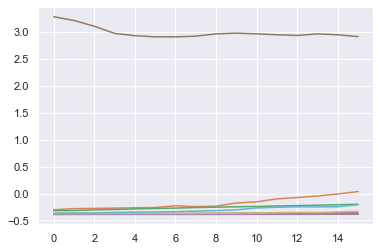

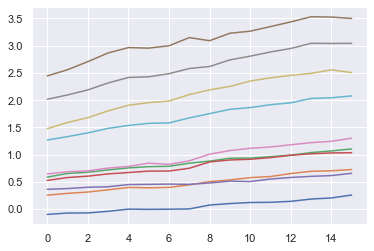

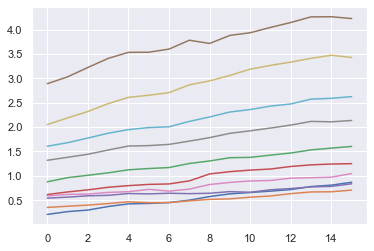

In [72]:
plt.figure()
plt.plot((obs_data - mean)/stdev)
plt.figure()
plt.plot(S[:,1,:])
plt.figure()
plt.plot(S[:,2,:])